In [1]:
# pip install tabulate

In [2]:
# pip freeze

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.impute import KNNImputer
from sklearn.exceptions import UndefinedMetricWarning
import warnings
import seaborn as sns
from tabulate import tabulate

In [4]:
# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Step 1. Data Scrapping

The dataset was obtained by scraping 4100 apartment rental listings from Kijiji for Toronto city. Details such as rental costs, apartment sizes, the number of bedrooms and bathrooms, amenities, and building types were taken from the HTML structure of the website using Beautiful Soup, a Python web scraping tool.<br>
The code used for scraping propose is combination of 2 files which are included along with the project under the folder 'Scraping script'

In [5]:
# loading the data from given github page
df=pd.read_csv('kijiji_rental_ads_4106.csv')
df1=df.copy()

## Step 2 : Data Description and Wrangling

**2.1 Understanding the data**

In [6]:
df.shape

(4106, 23)

In [7]:
df.head(2)

,Title,Price($),Address,Date Posted,Building Type,Bedrooms,Bathrooms,Utilities,Wi-Fi and More,Parking Included,...,Size (sqft),Furnished,Air Conditioning,Personal Outdoor Space,Smoking Permitted,Appliances,Amenities,Description,Visit Counter,url
0,6020 Bathurst Street - Valencia Towers Apartme...,3209.0,"6020 Bathurst Street, Toronto, ON, M2R 1Z8",2024-02-24 23:30:00,Apartment,2,1,NaN,Not Included,0,...,912,No,No,Not Included,No,Fridge / Freezer,Elevator in Building,Valencia Towers is a student- and family-frien...,NaN,https://www.kijiji.ca/v-apartments-condos/city...
1,RENOVATED BACHELOR SUITE AVAILABLE! Lakeview ...,2000.0,"22 Close Avenue, Toronto, ON, M6K 2V2",2024-03-14 00:09:49,Apartment,Bachelor/Studio,1,"Hydro_No,Heat_No,Water_Yes",Not Included,0,...,445,No,No,Balcony,No,"Laundry (In Building), Fridge / Freezer","Gym, Pool, Storage Space, Elevator in Building","Bachelors, 1 Bath, Recently Renovated Kitchen ...",NaN,https://www.kijiji.ca/v-apartments-condos/city...


In [8]:
df.tail(2)

,Title,Price($),Address,Date Posted,Building Type,Bedrooms,Bathrooms,Utilities,Wi-Fi and More,Parking Included,...,Size (sqft),Furnished,Air Conditioning,Personal Outdoor Space,Smoking Permitted,Appliances,Amenities,Description,Visit Counter,url
4104,Basement Apartment Rental - Newly Renovated,2100.0,"Scarborough, ON M1K 2T9",NaN,Basement,1 + Den,1,"Hydro_Yes,Heat_Yes,Water_Yes",Internet,1,...,"1,000",No,Yes,Not Included,No,"Laundry (In Building), Fridge / Freezer",NaN,Basement Apartment Rental - Short term Rental ...,267 visits,https://www.kijiji.ca/v-apartments-condos/city...
4105,Spacious 2 Bedroom Apartment - North York -Wai...,2450.0,"50 Graydon Hall Drive, North York, ON, M3A 3A3",NaN,Apartment,2,1,"Hydro_Yes,Heat_Yes,Water_Yes",Not Included,0,...,Not Available,No,No,Balcony,Yes,"Laundry (In Building), Dishwasher, Fridge / Fr...",NaN,Style 2F - waiting list in effect - please cal...,NaN,https://www.kijiji.ca/v-apartments-condos/city...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106 entries, 0 to 4105
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   4099 non-null   object 
 1   Price($)                3850 non-null   float64
 2   Address                 4094 non-null   object 
 3   Date Posted             3498 non-null   object 
 4   Building Type           3081 non-null   object 
 5   Bedrooms                3081 non-null   object 
 6   Bathrooms               3081 non-null   object 
 7   Utilities               2138 non-null   object 
 8   Wi-Fi and More          3081 non-null   object 
 9   Parking Included        3081 non-null   object 
 10  Agreement Type          3081 non-null   object 
 11  Move-In Date            2008 non-null   object 
 12  Pet Friendly            3759 non-null   object 
 13  Size (sqft)             3083 non-null   object 
 14  Furnished               4059 non-null   

In [10]:
df.describe(percentiles=[0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99]).round(1)

,Price($)
count,3850.0
mean,2605.8
std,18485.3
min,20.0
1%,400.0
10%,950.0
20%,1450.0
30%,1800.0
40%,1975.0
50%,2184.5


**2.2 Data Wrangling**

**2.2.1 Handling Inconsistent Data**

**2.2.1.1 Duplicates**

In [11]:
# Check for duplicate rows
duplicate_rows = df.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()

# Print the number of duplicate rows
print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 511


**Observation** <br>
There are 489 duplicates row which might cause issue EDA and analysis so we are dropping the duplicates.

In [12]:
# Drop duplicate rows from the DataFrame
df.drop_duplicates(inplace=True)

**2.2.1.2 Inconsistent**

In [13]:
# Use regular expressions to keep only digits or NaN for visit counter column
df['Visit Counter'] = df['Visit Counter'].apply(lambda x: re.sub(r'\D', '', str(x)))

# Convert the column to integer type
df['Visit Counter'] = pd.to_numeric(df['Visit Counter'], errors='coerce', downcast='integer')

In [14]:
df['Visit Counter'].max()

9452.0

In [15]:
# Mapping of utilities string values to integer values
mapping = {
    'Hydro_Yes,Heat_Yes,Water_Yes': 3,
    'Hydro_Yes,Heat_No,Water_Yes': 2,
    'Hydro_No,Heat_Yes,Water_Yes': 2,
    'Hydro_Yes,Heat_Yes,Water_No': 2,
    'Hydro_Yes,Heat_No,Water_No': 1,
    'Hydro_No,Heat_No,Water_Yes': 1,
    'Hydro_No,Heat_Yes,Water_No': 1
}

# Replace values in the 'Utilities' column using the mapping
df['Utilities'] = df['Utilities'].replace(mapping)


In [16]:
# change 'Not available' of size to nan to apply imputation
df['Size (sqft)'] = df['Size (sqft)'].replace('Not Available', np.nan)
# Convert the column to float
df['Size (sqft)'] = pd.to_numeric(df['Size (sqft)'], errors='coerce')

In [17]:
# drop the data which are empty > 50% or add veru little value in further steps
df.drop(columns=['Amenities'], inplace=True)
df.drop('Appliances', axis=1, inplace=True)
df.drop('Move-In Date', axis=1, inplace=True)
# df.drop('Date Posted', axis=1, inplace=True)


In [18]:
# Replace 'Not available' with 'Not disclosed'
df['Agreement Type'] = df['Agreement Type'].replace('Not available', 'Not disclosed')

**2.2.2 Handling Missing Values**

In [19]:
df.isnull().sum()

Title                        7
Price($)                   251
Address                     12
Date Posted                608
Building Type             1006
Bedrooms                  1006
Bathrooms                 1006
Utilities                 1776
Wi-Fi and More            1006
Parking Included          1006
Agreement Type            1006
Pet Friendly               343
Size (sqft)               1723
Furnished                   47
Air Conditioning          1006
Personal Outdoor Space    1006
Smoking Permitted         1006
Description                173
Visit Counter             1229
url                          0
dtype: int64

In [20]:
# Looking at the null percentage of each columns
from tabulate import tabulate

# Calculate null percentage of each column
null_percentages = (df.isnull().mean() * 100).round(2).astype(str) + '%'

# Filter out columns with no missing values
null_percentages = null_percentages[null_percentages != '0.0%']

# Sort null percentages in descending order
null_percentages_sorted = null_percentages.sort_values(ascending=True)

# Create a list of lists containing column names and null percentages
data = []
for column, percentage in null_percentages_sorted.items():
    data.append([column, percentage])

# Define column headers
headers = ["Column", "Null Percentage"]

# Print the table using tabulate
print(tabulate(data, headers=headers, tablefmt="fancy_grid"))


╒════════════════════════╤═══════════════════╕
│ Column                 │ Null Percentage   │
╞════════════════════════╪═══════════════════╡
│ Title                  │ 0.19%             │
├────────────────────────┼───────────────────┤
│ Address                │ 0.33%             │
├────────────────────────┼───────────────────┤
│ Furnished              │ 1.31%             │
├────────────────────────┼───────────────────┤
│ Date Posted            │ 16.91%            │
├────────────────────────┼───────────────────┤
│ Smoking Permitted      │ 27.98%            │
├────────────────────────┼───────────────────┤
│ Personal Outdoor Space │ 27.98%            │
├────────────────────────┼───────────────────┤
│ Air Conditioning       │ 27.98%            │
├────────────────────────┼───────────────────┤
│ Agreement Type         │ 27.98%            │
├────────────────────────┼───────────────────┤
│ Parking Included       │ 27.98%            │
├────────────────────────┼───────────────────┤
│ Bathrooms  

**Observation** <br>
Most of data has null count of around 25% which we can drop or impute based on their importance. Columns Visitor count and Size have more 40% null values but the columns can be imputed instead of dropping as they can provide valueable insight in the analysis part.

**2.2.2.1 Dropping null values**

In [21]:
df = df[(df['Building Type'].notna() & (df['Building Type'] != '') & (df['Building Type'] != 'Not Available'))]

df.shape

(2589, 20)

In [22]:
"""those rows with no price were traced manually and found that those were the urls already removed from kijiji from url extraction time to actual
data scrape time hence we are dropping those rows"""

df.dropna(subset=['Price($)'], inplace=True)

**2.2.2.2 KNN Imputer**

In [23]:
imputer = KNNImputer(n_neighbors=5)

In [24]:
# imputing missing values for visit counter column
df['Visit Counter'] = imputer.fit_transform(df[['Visit Counter']])
df['Visit Counter'] = df['Visit Counter'].astype(int)

In [25]:

df['Utilities'] = imputer.fit_transform(df[['Utilities']])
df['Utilities'] = df['Utilities'].astype(int)
df['Utilities'].unique()


array([2, 1, 3])

In [26]:
df['Size (sqft)'] = imputer.fit_transform(df[['Size (sqft)']])
df['Size (sqft)'] = df['Size (sqft)'].astype(float)

In [27]:
# Calculate the mean excluding zeros
mean_visitor_counter = df[df['Visit Counter'] > 0]['Visit Counter'].mean()

# Replace zeros with the calculated mean for Log transformation
df['Visit Counter'] = df['Visit Counter'].replace(0, mean_visitor_counter)

**2.2.3 Feature Engineering**

New column days_posted_ago is added to dataframe obtained by subtracting Date posted from current date. Addition of new column can help us discover unique insight to the dataset.

In [28]:
df['Date Posted'] = pd.to_datetime(df['Date Posted'], errors='coerce')

# Calculate the difference in days since today for non-NaN values
df['days_posted_ago'] = (pd.Timestamp.now() - df['Date Posted']).dt.days

# Replace NaN values with NaN (no change)
df['days_posted_ago'].fillna(pd.NA, inplace=True)

# If you want to convert negative values to 0 (since they are in the future)
df['days_posted_ago'] = df['days_posted_ago'].clip(lower=0)

# Convert the result to integer type
df['days_posted_ago'] = df['days_posted_ago'].astype('Int64')


In [29]:
mode_days_posted_ago = df['days_posted_ago'].mode()[0]

# Fill null values in 'days_posted_ago' with the mode
df['days_posted_ago'].fillna(mode_days_posted_ago, inplace=True)

# Convert the 'days_posted_ago' column to integer type
df['days_posted_ago'] = df['days_posted_ago'].astype(int)

In [30]:
count_utilities_in_description = df[df['Utilities'].isna() & df['Description'].str.contains('utilities included', case=False)].shape[0]
print(count_utilities_in_description)

0


In [31]:
# Filling 'Utilities' column where 'Description' contains 'utilities included' and 'Utilities' column is null
# df.loc[df['Description'].str.contains('utilities included', case=False) & df['Utilities'].isna(), 'Utilities'] = 'Hydro_Yes,Heat_Yes,Water_Yes'


In [32]:
# Filter the DataFrame, dropping rows with NaN values in the 'Description' column
filtered_df = df.dropna(subset=['Description'])

# Filter further based on the condition
filtered_df = filtered_df[filtered_df['Description'].str.contains('utilities included', case=False)]

# Print the filtered DataFrame
# Print the lowercase version of the part after 'utilities included' in each description
print(filtered_df['Description'].apply(lambda x: x.lower()).str.split('utilities included').str[1])



14                                                       
15                                                       
16                                                       
21                                                       
22                                                       
                              ...                        
3938    .\nif you have a unit or know of a unit that i...
4031                     , not more than 3 people allowed
4033    . lots of natural light. lovely quiet building...
4052     (heat, a/c, water -no smoking, no pets, no su...
4104                                    - $2100 per month
Name: Description, Length: 240, dtype: object


In [33]:
#splitting into numeric and categorical dataframe
numeric_columns = df.select_dtypes(include=np.number).columns
categorical_columns = df.select_dtypes(exclude=np.number).columns

In [34]:
print(categorical_columns)

Index(['Title', 'Address', 'Date Posted', 'Building Type', 'Bedrooms',
       'Bathrooms', 'Wi-Fi and More', 'Parking Included', 'Agreement Type',
       'Pet Friendly', 'Furnished', 'Air Conditioning',
       'Personal Outdoor Space', 'Smoking Permitted', 'Description', 'url'],
      dtype='object')


In [35]:
print(numeric_columns)

Index(['Price($)', 'Utilities', 'Size (sqft)', 'Visit Counter',
       'days_posted_ago'],
      dtype='object')


In [36]:
df['Agreement Type'].value_counts()

Agreement Type
1 Year            2049
Month-to-month     306
Not Available       95
Name: count, dtype: int64

In [37]:
# looking the unique values in dataframe
cols = ['Building Type', 'Bedrooms', 'Bathrooms',
       'Utilities', 'Wi-Fi and More', 'Parking Included', 'Agreement Type',
       'Pet Friendly', 'Furnished', 'Air Conditioning',
       'Personal Outdoor Space', 'Smoking Permitted']

for col in cols:
    unique_values = df[col].unique()
    print(f"\nUnique values for {col}: {unique_values}")



Unique values for Building Type: ['Apartment' 'Condo' 'Basement' 'House' 'Duplex/Triplex' 'Townhouse']

Unique values for Bedrooms: ['2' 'Bachelor/Studio' '1' '3' '2 + Den' '1 + Den' '3 + Den' '4' '5+'
 '4 + Den']

Unique values for Bathrooms: ['1' '1.5' '2' '2.5' '3' '6+']

Unique values for Utilities: [2 1 3]

Unique values for Wi-Fi and More: ['Not Included' 'Internet' 'Cable / TVInternet' 'Cable / TV']

Unique values for Parking Included: ['0' '1' '2' '3+']

Unique values for Agreement Type: ['1 Year' 'Month-to-month' 'Not Available']

Unique values for Pet Friendly: ['Yes' 'Limited' 'No']

Unique values for Furnished: ['No' 'Yes']

Unique values for Air Conditioning: ['No' 'Yes' 'Not Available']

Unique values for Personal Outdoor Space: ['Not Included' 'Balcony' 'Yard' 'YardBalcony']

Unique values for Smoking Permitted: ['No' 'Yes' 'Outdoors only']


In [38]:
print((df.isnull().mean() * 100).round(2).astype(str) + '%')


Title                       0.0%
Price($)                    0.0%
Address                     0.0%
Date Posted               14.86%
Building Type               0.0%
Bedrooms                    0.0%
Bathrooms                   0.0%
Utilities                   0.0%
Wi-Fi and More              0.0%
Parking Included            0.0%
Agreement Type              0.0%
Pet Friendly                0.0%
Size (sqft)                 0.0%
Furnished                   0.0%
Air Conditioning            0.0%
Personal Outdoor Space      0.0%
Smoking Permitted           0.0%
Description                6.33%
Visit Counter               0.0%
url                         0.0%
days_posted_ago             0.0%
dtype: object


In [39]:
df.shape

(2450, 21)

## Step 3: Exploratory Data Analysis (EDA)

**3.1 Summary Statistics**

In [40]:
# Calculate summary statistics
summary_stats = df.describe()
# Transpose for better readability
summary_stats_df = summary_stats.T

# Print the summary statistics table
print(tabulate(summary_stats_df, headers='keys', tablefmt='fancy_grid'))

╒═════════════════╤═════════╤═══════════════════════════════╤═════════════════════╤═════════════════════╤════════════════════════════╤════════════════════════════╤═════════════════════╤═════════════╕
│                 │   count │ mean                          │ min                 │ 25%                 │ 50%                        │ 75%                        │ max                 │         std │
╞═════════════════╪═════════╪═══════════════════════════════╪═════════════════════╪═════════════════════╪════════════════════════════╪════════════════════════════╪═════════════════════╪═════════════╡
│ Price($)        │    2450 │ 2554.746530612245             │ 99.0                │ 1900.0              │ 2299.0                     │ 2699.0                     │ 245000.0            │ 6068.24     │
├─────────────────┼─────────┼───────────────────────────────┼─────────────────────┼─────────────────────┼────────────────────────────┼────────────────────────────┼─────────────────────┼─────────────┤


**3.2 Distribution of Numeric Variables**

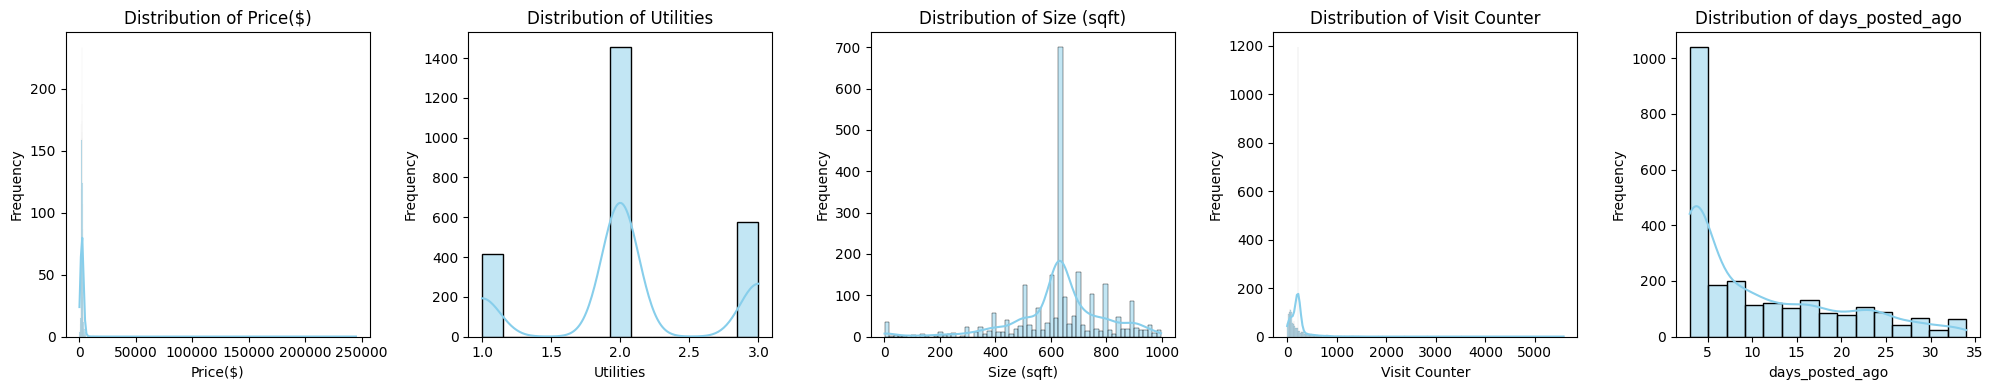

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

num_plots = len(numeric_columns)
# 4 columns per row
num_cols = min(5, num_plots)

num_rows = (num_plots - 1) // num_cols + 1

fig, axes = plt.subplots(1, num_cols, figsize=(4 * num_cols, 4))

# Iterate through numeric columns and plot each one
for i, col in enumerate(numeric_columns):
    ax = axes[i]

    sns.histplot(df[col], kde=True, ax=ax,color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Remove empty plots if exists
if num_plots < num_cols:
    for i in range(num_plots, num_cols):
        axes[i].remove()

plt.tight_layout()
plt.show()


**Observation** <br>
Numeric columns are affected by outliers or skewness, suggesting the use of proper outlier handling and skewness removal techniques. Only the distribution of size exhibits a normal distribution.

**3.3 Univariate analysis**

**3.3.1 Bar chart**

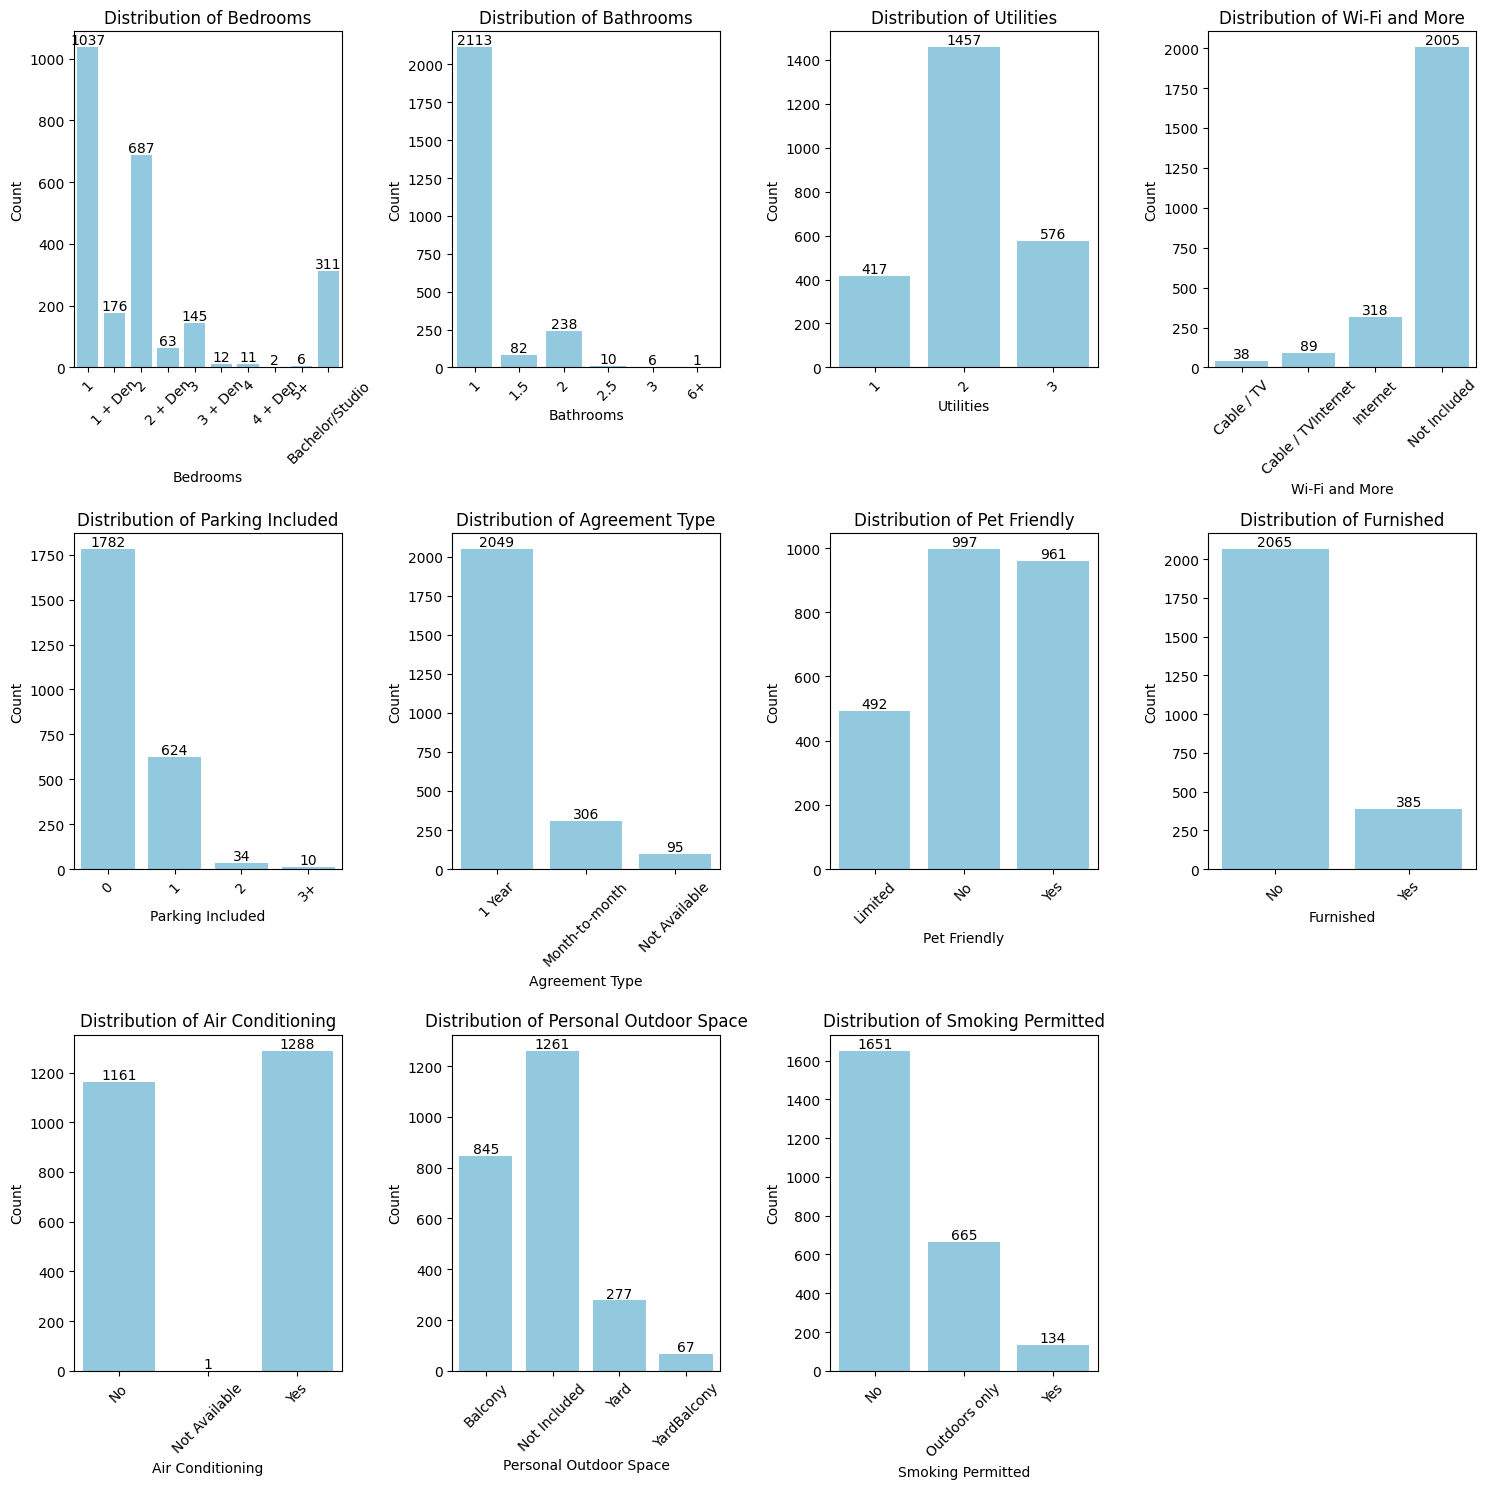

In [42]:
cols_for_plot = ['Bedrooms',
       'Bathrooms', 'Utilities', 'Wi-Fi and More', 'Parking Included',
       'Agreement Type', 'Pet Friendly', 'Furnished', 'Air Conditioning',
       'Personal Outdoor Space', 'Smoking Permitted']
cols_per_row = 4  # Number of columns per row
num_plots = len(cols_for_plot)
num_rows = (num_plots - 1) // cols_per_row + 1

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 5*num_rows))

# Iterate through columns and plot each one
for i, col in enumerate(cols_for_plot):
    row = i // cols_per_row
    col_idx = i % cols_per_row
    ax = axes[row] if num_rows == 1 else axes[row, col_idx]

    # Sort the data
    sorted_df = df[col].value_counts().sort_index()

    sns.barplot(x=sorted_df.index, y=sorted_df.values, ax=ax,color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

    # Add count values on top of each bar
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 5),
                    textcoords = 'offset points')

# Remove empty subplots if necessary
if num_plots < num_rows * cols_per_row:
    for i in range(num_plots, num_rows * cols_per_row):
        axes.flat[i].set_visible(False)


plt.tight_layout()
plt.show()

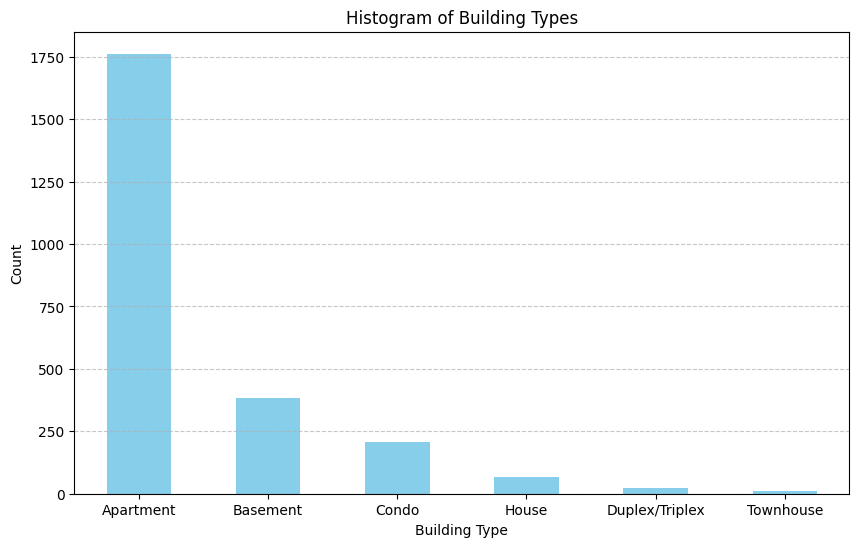

In [43]:
# Count the occurrences of each unique value in the 'Building Type' column
building_type_counts = df['Building Type'].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
building_type_counts.plot(kind='bar', color='skyblue', linewidth=1.2)

# Customize the plot
plt.title('Histogram of Building Types')
plt.xlabel('Building Type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=360)

# Show plot
plt.show()

**Observation** <br>
More than 2000 data are related to Apartment accounting for more than 70% of total data. Townhouse and Duplex/Triplex accounts for less than 5% each

**3.3.2 Pie Chart**

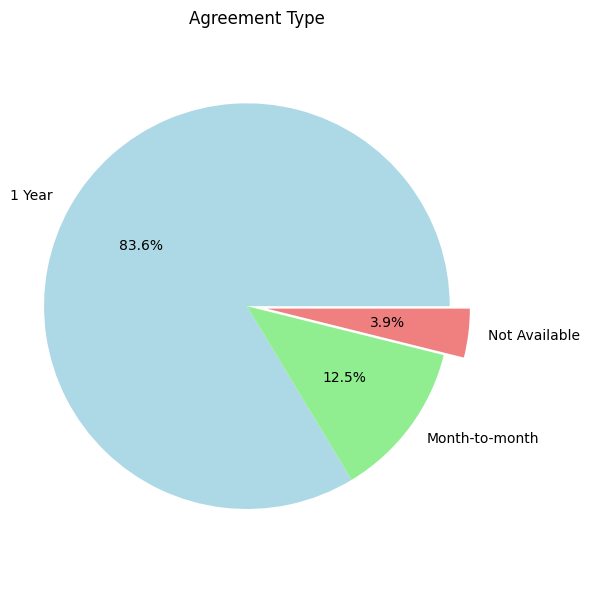

In [44]:
column_name = 'Agreement Type'
# Counting the occurrences of each unique value in the selected column
column_count = df[column_name].value_counts()
explode = (0, 0, 0.1)

# Plotting the pie chart
plt.figure(figsize=(6, 6))

# color defination
colors = ['lightblue', 'lightgreen', 'lightcoral', 'orange', 'yellow']

plt.pie(column_count, labels=column_count.index, colors=colors,
        autopct='%1.1f%%', explode = explode)
plt.title(f'{column_name}')
plt.axis('equal')
plt.tight_layout()
plt.show()


**Observation** <br>
Most Landlords / Company publishing advertisement in Kijiji prefers Yearly Lease agreement. Only 10.8% prefer Month to month lease agreement.

**3.4 Bi-variate analysis**

**3.4.1 Bar Graph**

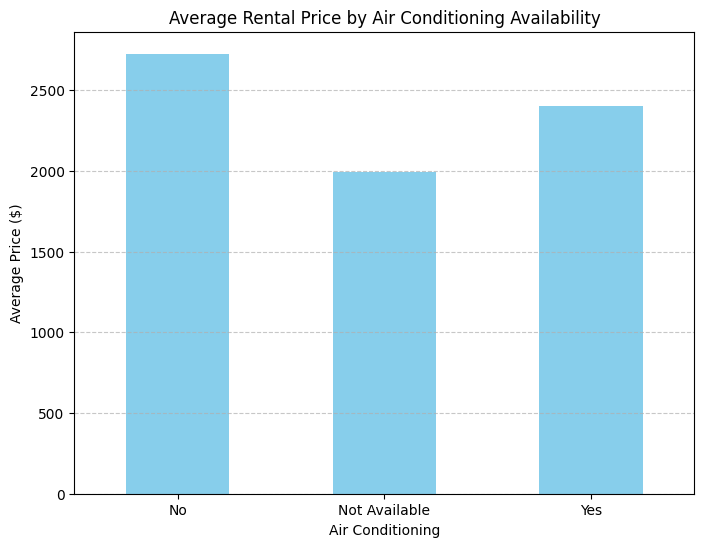

In [45]:
# Grouping data based on Air Conditioning availability and calculating average price
average_price_ac = df.groupby('Air Conditioning')['Price($)'].mean()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
average_price_ac.plot(kind='bar', color=['skyblue'])
plt.title('Average Rental Price by Air Conditioning Availability')
plt.xlabel('Air Conditioning')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Observation** <br>
Average Price of Apartment without Air conditioning is higher than Apartment with no Air conditioning which is opposite of expected. It might be due to bias present in data.

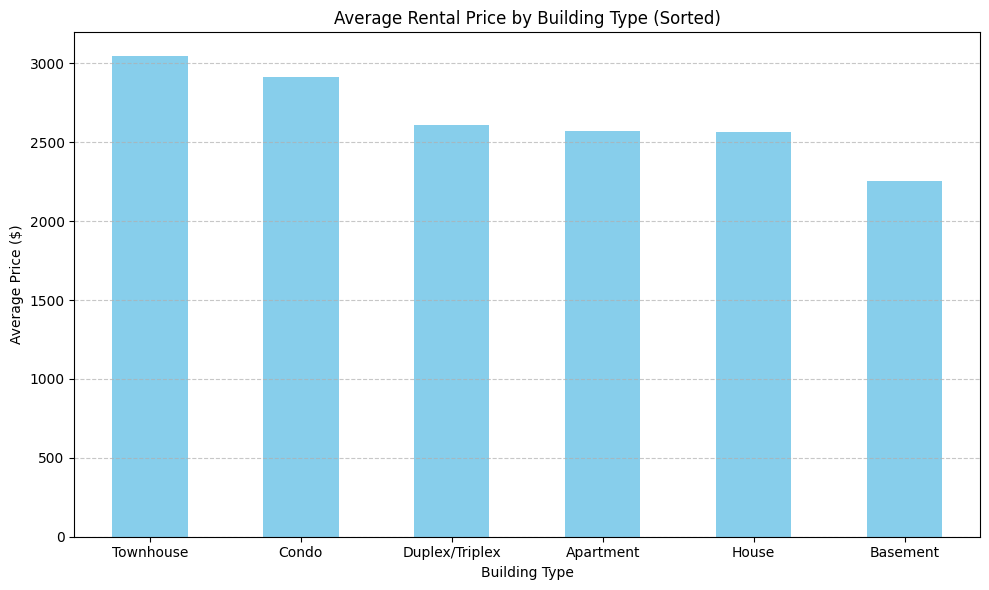

In [46]:

# Grouping data based on Building Type and calculating average price
average_price_building_type = df.groupby('Building Type')['Price($)'].mean()

# Sorting the average prices in descending order
average_price_building_type_sorted = average_price_building_type.sort_values(ascending=False)

# Plotting the sorted bar plot
plt.figure(figsize=(10, 6))
average_price_building_type_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Rental Price by Building Type (Sorted)')
plt.xlabel('Building Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()



**Observation** <br>
Average rental price of Townhouse is highest with around CAD 3000 per month whereas same for Basement is lowest with slightly above CAD 2000 per month.

<Figure size 1000x600 with 0 Axes>

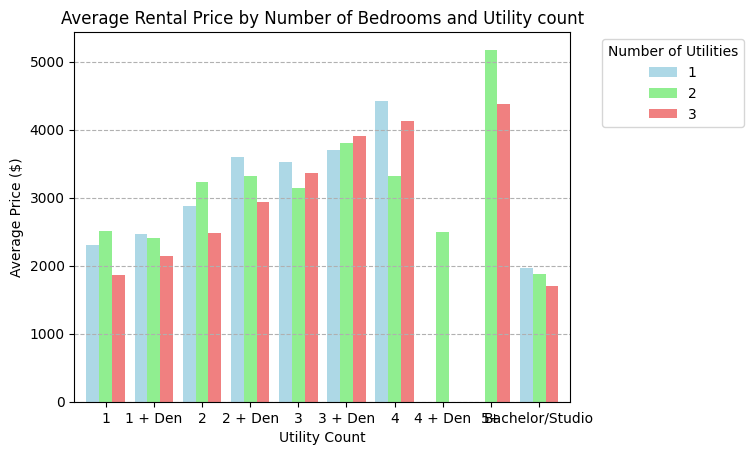

In [47]:
# Grouping data based on 'Pet Friendly' and 'Building Type', and calculating average price
average_price_pet_building = df.groupby(['Bedrooms','Utilities'])['Price($)'].mean().unstack()

# Plotting the grouped bar plot
plt.figure(figsize=(10, 6))
ax = average_price_pet_building.plot(kind='bar', color = ['lightblue', 'lightgreen', 'lightcoral'], width=0.8)
plt.title('Average Rental Price by Number of Bedrooms and Utility count')
plt.xlabel('Utility Count')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# Adjusting legend position
plt.legend(title='Number of Utilities', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.99)
plt.show()

**Observation** <br>
Apartment's price increase when number of utilities + bedroom increase as shown in above figure. Due to logical issue in processing in data with null utilities, in some category rentals with 2 utilities is higher than that of 3 utilities.

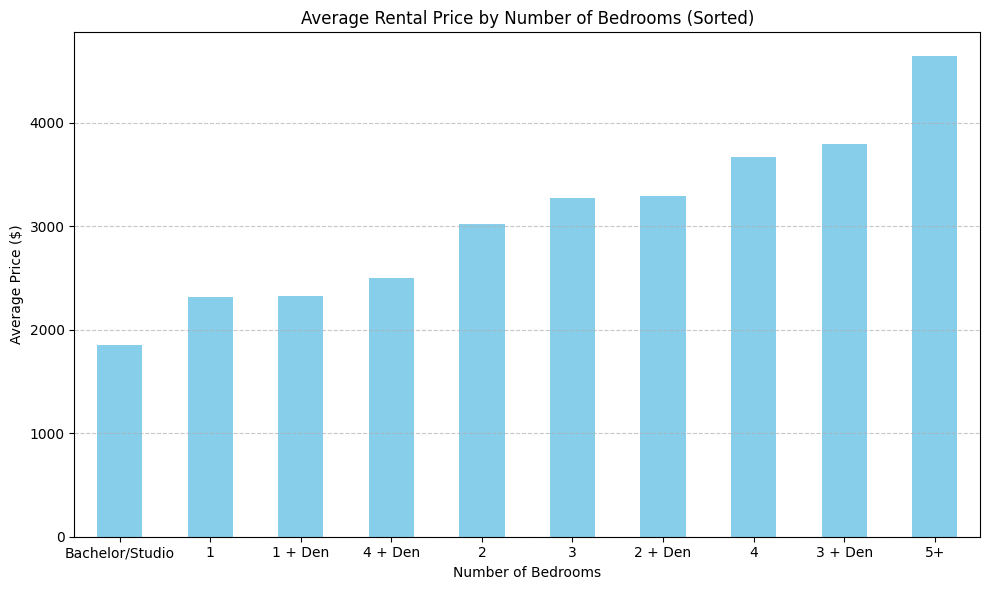

In [48]:


# Grouping data based on number of bedrooms and calculating average price
average_price_bedrooms = df.groupby('Bedrooms')['Price($)'].mean()

# Sorting the average prices in ascending order
average_price_bedrooms_sorted = average_price_bedrooms.sort_values()

# Plotting the sorted bar plot
plt.figure(figsize=(10, 6))
average_price_bedrooms_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Rental Price by Number of Bedrooms (Sorted)')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


**Observation** <br>
Average rental price of 5+ bedrooms is highest with rent more CAD 4500 per month and rent for Studio apartment is slightly less than CAD 2000 with increase in price with increase in bedroom number eith exception for 4 + Den bedroom.

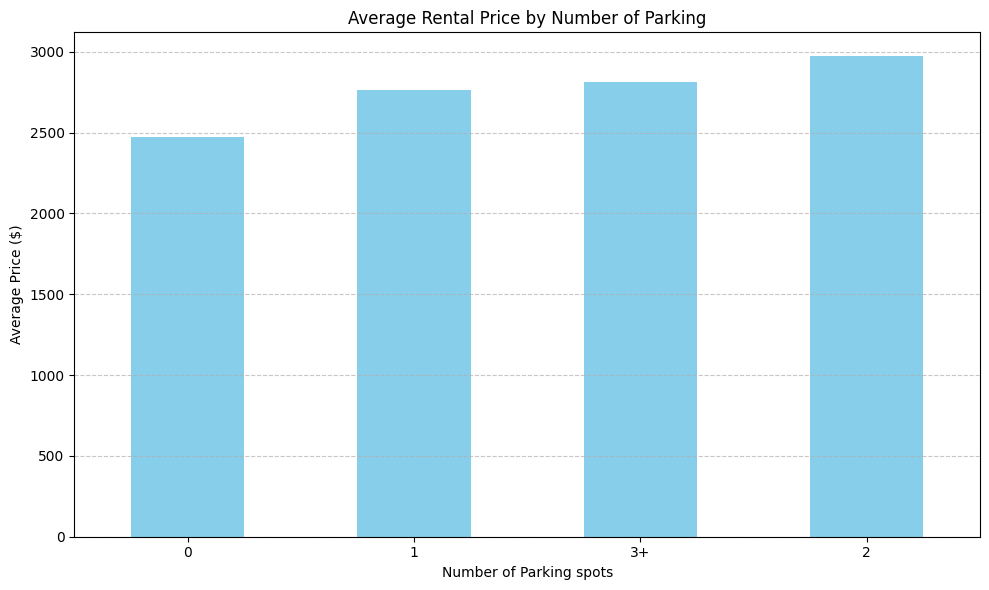

In [49]:

# Grouping data based on number of bedrooms and calculating average price
average_price_parking = df.groupby('Parking Included')['Price($)'].mean()

# Sorting the average prices in ascending order
average_price_parking_sorted = average_price_parking.sort_values()

# Plotting the sorted bar plot
plt.figure(figsize=(10, 6))
average_price_parking_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Rental Price by Number of Parking')
plt.xlabel('Number of Parking spots')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

**Observation** <br>
Average rental price with 2 Parking spots is highest with rent around CAD 3000 per month and rent for apartment with 0 parking spot is the lowest at around CAD 2500

<Figure size 46000x15000 with 0 Axes>

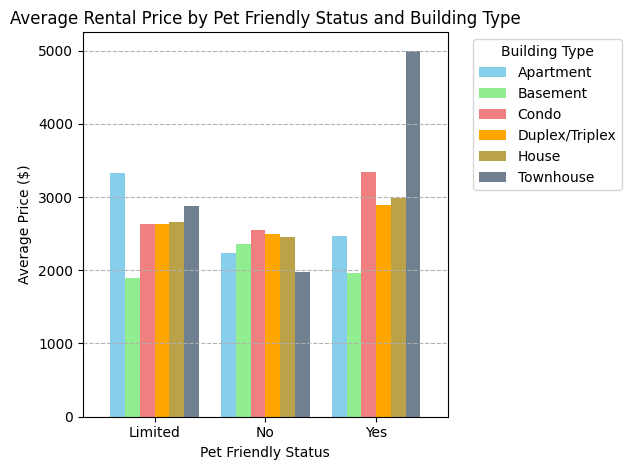

In [50]:
# Grouping data based on 'Pet Friendly' and 'Building Type', and calculating average price
average_price_pet_building = df.groupby(['Pet Friendly', 'Building Type'])['Price($)'].mean().unstack()

# Plotting the grouped bar plot
plt.figure(figsize=(460, 150))
ax = average_price_pet_building.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral', 'orange', '#bba147', '#708090'], width=0.8)
plt.title('Average Rental Price by Pet Friendly Status and Building Type')
plt.xlabel('Pet Friendly Status')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# Adjusting legend position
plt.legend(title='Building Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.99)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


**Observation** <br>
On general analysis, Apartment's price increase when the pet friendly status is limited and is highest when the status is Positive.

**3.4.2 Scatter Plot**

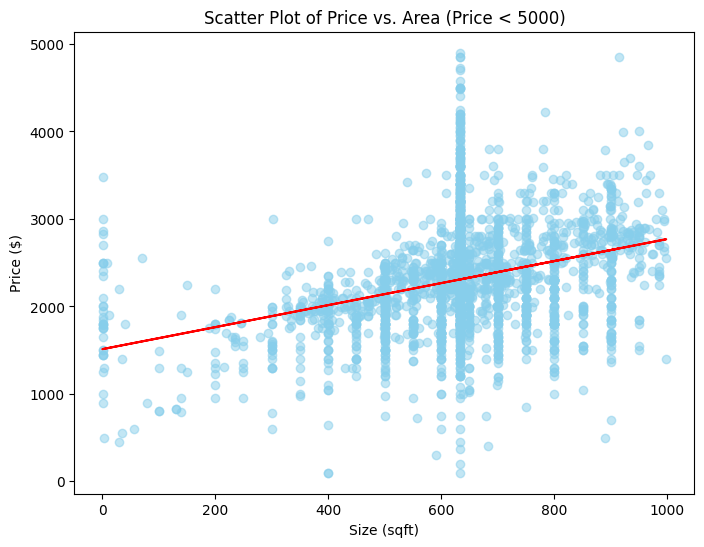

In [51]:
import matplotlib.pyplot as plt

# Filter out data where price is less than 5000
filtered_df = df[(df['Price($)'] < 5000) & (df['Size (sqft)'] > 0)]

# Create scatter plot with filtered data
plt.figure(figsize=(8, 6))
plt.scatter(filtered_df['Size (sqft)'], filtered_df['Price($)'], alpha=0.5, color= 'skyblue')
plt.title('Scatter Plot of Price vs. Area (Price < 5000)')
plt.xlabel('Size (sqft)')
plt.ylabel('Price ($)')

# Fit a linear regression line
x = filtered_df['Size (sqft)']
y = filtered_df['Price($)']
m, b = np.polyfit(x, y, 1)  # Fit a first degree polynomial (linear regression)
plt.plot(x, m*x + b, color='red')  # Plot the regression line

plt.show()



**Observation** <br>
Size in Square feet has positive correlation with Price. The red line represents positive correlation between these 2 variables.

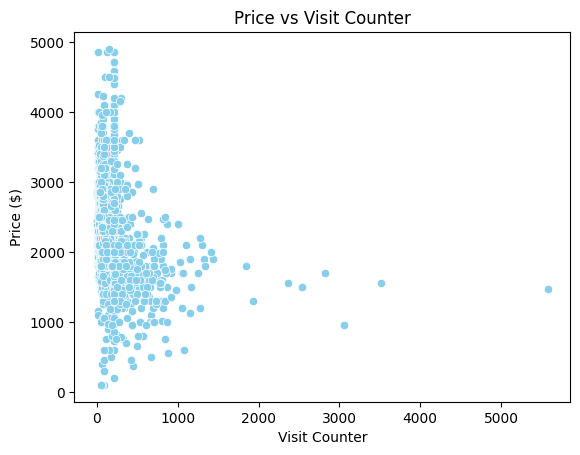

In [52]:
# Scatter plot for 'Price($)' vs 'Visit Counter'
sns.scatterplot(x='Visit Counter', y='Price($)', data=filtered_df, color = 'skyblue')
plt.title('Price vs Visit Counter')
plt.xlabel('Visit Counter')
plt.ylabel('Price ($)')
plt.show()

**Observation** <br>
Ads are mostly viewed between 0-1000 times as suggested by the plot. There is no clear relation between Price and visitor count but it can be inferred the figure is slightly affected by outliers present in visitor count category.

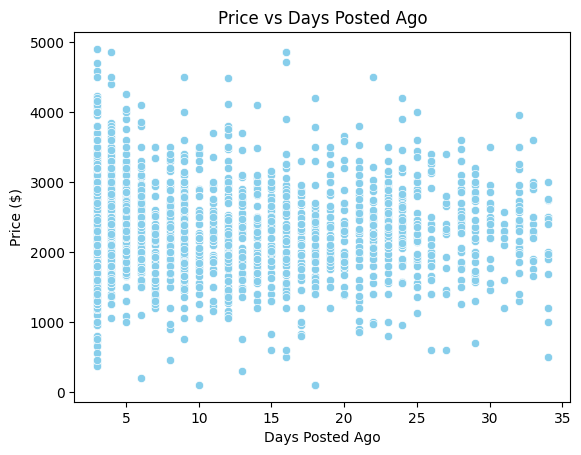

In [53]:
# Scatter plot for 'Price($)' vs 'days_posted_ago'
sns.scatterplot(x='days_posted_ago', y='Price($)', data=filtered_df, color= 'skyblue')
plt.title('Price vs Days Posted Ago')
plt.xlabel('Days Posted Ago')
plt.ylabel('Price ($)')
plt.show()

**Observation** <br>
Most of the Ads are published recently and it also signifies the ads were fetched based on recency(which is true). Ads posted more than 20 days are in range of less than CAD 4000 suggesting the ads of apartment costing more than CAD are either not published or been taken down due to being booked or some other reason by Ad publisher.

**3.4.3 Corelation matrix**

In [54]:
df.dtypes

Title                             object
Price($)                         float64
Address                           object
Date Posted               datetime64[ns]
Building Type                     object
Bedrooms                          object
Bathrooms                         object
Utilities                          int32
Wi-Fi and More                    object
Parking Included                  object
Agreement Type                    object
Pet Friendly                      object
Size (sqft)                      float64
Furnished                         object
Air Conditioning                  object
Personal Outdoor Space            object
Smoking Permitted                 object
Description                       object
Visit Counter                    float64
url                               object
days_posted_ago                    int32
dtype: object

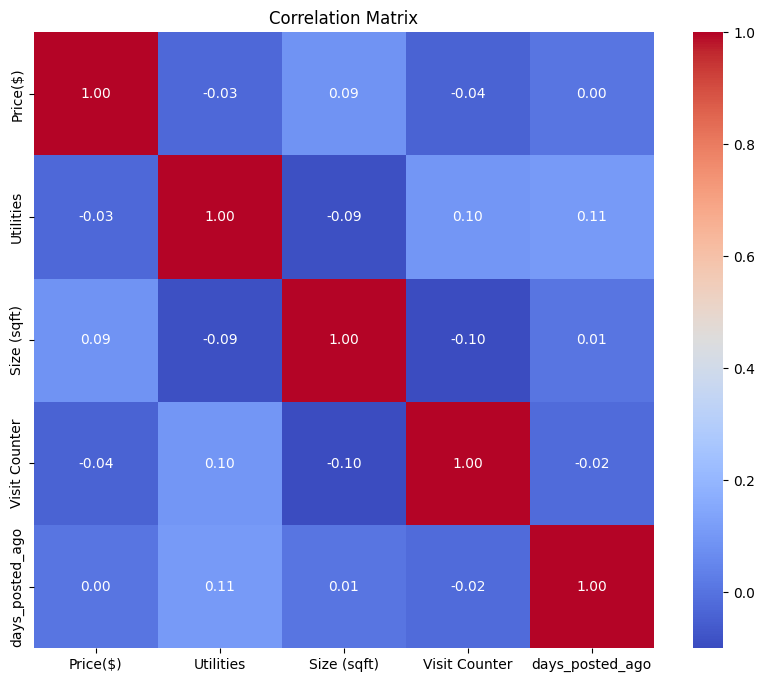

In [55]:
# Excluding non-numeric columns from correlation matrix calculation
numeric_df = df.select_dtypes(include=['number'])

# Generating correlation matrix
correlation_matrix = numeric_df.corr()

# Plotting correlation matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


## Step 4: Using Pandas Profiling for EDA

In [69]:
pip install ydata-profiling

     -------------------------------------- 357.9/357.9 kB 7.6 MB/s eta 0:00:00
  Using cached visions-0.7.5-py3-none-any.whl (102 kB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
     ---------------------------------------- 9.9/9.9 MB 23.3 MB/s eta 0:00:00
  Using cached typeguard-4.1.5-py3-none-any.whl (34 kB)
  Using cached dacite-1.8.1-py3-none-any.whl (14 kB)
     ---------------------------------------- 2.6/2.6 MB 20.8 MB/s eta 0:00:00
     --------------------------------------- 28.1/28.1 MB 18.7 MB/s eta 0:00:00
     ---------------------------------------- 233.9/233.9 kB ? eta 0:00:00
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.3
    Uninstalling patsy-0.5.3:
      Successfully uninstalled patsy-0.5.3
  Attempting uninstall: visions
    Found existing installation: visions 0.7.4
    Uninstalling visions-0.7.4:
      Successfully uninstalled visions-0.7.4
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
   

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires visions[type_image_path]==0.7.4, but you have visions 0.7.5 which is incompatible.

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: C:\Users\TravelMate\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [70]:
from ydata_profiling import ProfileReport


In [71]:
profile = ProfileReport(df, title="Profiling Report")


In [72]:
profile.to_file('pandas_profiling_report_toronto_rental.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Step 5: Data encoding for categorical columns

**5.1 Custom Encoding methods based on scenario**

In [73]:
# custom method for converting categorical columns to numeric columns based on
# context of data
def convert_bedroom_value(value):
    # Check if the value is already numeric or a string
    if pd.notnull(value):
        # Process non-numeric string values
        if value == 'Bachelor/Studio':
            num_bedrooms = 1
        elif '+' in value:
            parts = value.split('+')
            num_bedrooms = float(parts[0])
        else:
            num_bedrooms = float(value)
        return num_bedrooms
    else:
        # Return 0 for non-string or already numeric values
        return 0


def remove_plus(value):
     # Check if the value is None or NaN
    if pd.isna(value):
        return np.nan

    # If not a float and not NaN, remove the '+' sign using regular expressions and convert to float
    return float(re.sub(r'\+', '', str(value)))

def convert_to_numeric(value):
    if pd.isna(value):
        return np.nan
    elif value == 'Yes':
        return 1
    elif value == 'No':
        return 0
    elif value == 'Limited' or value == 'Outdoors only':
        return 0.5
    elif value == 'Not Available':
        return 0
    else:
        return value


In [74]:
# Convert the 'Bedrooms' column to numeric
df['Bedrooms'] = pd.to_numeric(df['Bedrooms'].apply(convert_bedroom_value))
# Convert the 'Bedrooms' column to numeric
df['Bathrooms'] = pd.to_numeric(df['Bathrooms'].apply(remove_plus))
# Convert the 'Bedrooms' column to numeric
df['Parking Included'] = pd.to_numeric(df['Parking Included'].apply(remove_plus))


In [75]:
df['Pet Friendly'] = pd.to_numeric(df['Pet Friendly'].apply(convert_to_numeric))
df['Air Conditioning'] = pd.to_numeric(df['Air Conditioning'].apply(convert_to_numeric))
df['Smoking Permitted'] = pd.to_numeric(df['Smoking Permitted'].apply(convert_to_numeric))

In [76]:
# df.head()
df['Bathrooms'].value_counts()

Bathrooms
1.0    2113
2.0     238
1.5      82
2.5      10
3.0       6
6.0       1
Name: count, dtype: int64

In [77]:
# find categorical and numerical columns after data encoding
numeric_columns = df.select_dtypes(include=np.number).columns
categorical_columns = df.select_dtypes(exclude=np.number).columns

In [78]:
print(numeric_columns)
print(categorical_columns)

Index(['Price($)', 'Bedrooms', 'Bathrooms', 'Utilities', 'Parking Included',
       'Pet Friendly', 'Size (sqft)', 'Air Conditioning', 'Smoking Permitted',
       'Visit Counter', 'days_posted_ago'],
      dtype='object')
Index(['Title', 'Address', 'Date Posted', 'Building Type', 'Wi-Fi and More',
       'Agreement Type', 'Furnished', 'Personal Outdoor Space', 'Description',
       'url'],
      dtype='object')


In [79]:
df.shape

(2450, 21)

**5.2 Label Encoding**

  For columns which we can rank numerically , we are using Label encoding. Furnished Apartment are ranked higher than Unfurnished ones so we are using Lable encoder on Furnished column.

In [80]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to your categorical column and transform it
encoded_labels = label_encoder.fit_transform(df['Furnished'])

# Replace the original column with the encoded labels
df['Furnished'] = encoded_labels


In [81]:
df.head()

,Title,Price($),Address,Date Posted,Building Type,Bedrooms,Bathrooms,Utilities,Wi-Fi and More,Parking Included,...,Pet Friendly,Size (sqft),Furnished,Air Conditioning,Personal Outdoor Space,Smoking Permitted,Description,Visit Counter,url,days_posted_ago
0,6020 Bathurst Street - Valencia Towers Apartme...,3209.0,"6020 Bathurst Street, Toronto, ON, M2R 1Z8",2024-02-24 23:30:00,Apartment,2.0,1.0,2,Not Included,0.0,...,1.0,912.000000,0,0,Not Included,0.0,Valencia Towers is a student- and family-frien...,218.0,https://www.kijiji.ca/v-apartments-condos/city...,22
1,RENOVATED BACHELOR SUITE AVAILABLE! Lakeview ...,2000.0,"22 Close Avenue, Toronto, ON, M6K 2V2",2024-03-14 00:09:49,Apartment,1.0,1.0,1,Not Included,0.0,...,1.0,445.000000,0,0,Balcony,0.0,"Bachelors, 1 Bath, Recently Renovated Kitchen ...",218.0,https://www.kijiji.ca/v-apartments-condos/city...,3
2,50 Driftwood - Ruby Heights Apartment for Rent,2819.0,"50 Driftwood, Toronto, ON, M3N 2M6",2024-03-03 00:08:58,Apartment,2.0,1.0,2,Not Included,0.0,...,1.0,904.000000,0,0,Not Included,0.0,"Ruby Heights, located in the North York distri...",218.0,https://www.kijiji.ca/v-apartments-condos/city...,14
3,1 Bed Apartment Rent today,2519.0,"100 Parkway Forest Drive, Toronto, ON, M2J 1L6",2024-03-06 00:35:06,Apartment,1.0,1.0,2,Not Included,0.0,...,0.5,665.000000,0,0,Yard,1.0,"For a limited time, you can receive ONE MONTH ...",218.0,https://www.kijiji.ca/v-apartments-condos/city...,11
4,Brand New 2-bedroom Rental in North York! Yor...,2690.0,"1225 York Road, Toronto, ON, M3A 1Y4",2024-03-04 00:39:41,Apartment,2.0,1.0,2,Not Included,0.0,...,1.0,632.446509,0,1,Balcony,1.0,Realstar's ONE225 York Mills is North Yorks ne...,218.0,https://www.kijiji.ca/v-apartments-condos/city...,13


**5.3 One Hot Encoding (OHE)**

For certain categorical columns such as Building type and personal outdoor space, we cannot rank them. We are using OHE to encode such columns for further analysis

In [82]:
# from sklearn.preprocessing import OneHotEncoder

# # Define the columns to be one-hot encoded
# columns_to_encode = ['Personal Outdoor Space', 'Building Type']

# # Create an instance of OneHotEncoder
# onehot_encoder = OneHotEncoder()

# # Fit the encoder to the selected columns and transform them
# onehot_encoded = onehot_encoder.fit_transform(df[columns_to_encode])

# # Convert the sparse matrix to a DataFrame
# onehot_encoded_df = pd.DataFrame(onehot_encoded.toarray(), columns=onehot_encoder.get_feature_names_out(columns_to_encode))

# # Concatenate the one-hot encoded DataFrame with the original DataFrame
# df = pd.concat([df, onehot_encoded_df], axis=1)

# # Drop the original categorical columns if needed
# df.drop(columns_to_encode, axis=1, inplace=True)


In [83]:
df.shape

(2450, 21)

## Step 6: Outlier Detection

In [84]:
def generate_box_plot(df, column, handled_outliers = False):
  sns.set(style="whitegrid")

  plt.figure(figsize=(8, 6))
  sns.boxplot(y=filtered_df[column], orient='v', color='skyblue')
  title = 'Boxplot of '+column + (' after' if handled_outliers else ' before') + ' outlier handling'
  plt.title(title)
  plt.ylabel(column)
  plt.show()

def generate_histogram(df, column, handled_outliers = False):
  plt.hist(data, bins=10)
  title = 'Histogram of '+column + (' after' if handled_outliers else ' before') + ' outlier handling'
  plt.title(title)
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.show()

def generate_plots(df, column, handled_outliers=False):
    # Set up the figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    title = ' of '+column + (' after' if handled_outliers else ' before') + ' outlier handling'

    # boxplot
    sns.boxplot(y=df[column], orient='v', color='skyblue', ax=axes[0], showfliers=False)
    axes[0].set_title('Boxplot '+ title)
    axes[0].set_ylabel(column)

    # histogram
    axes[1].hist(df[column], bins=100,color='skyblue')
    axes[1].set_title('Histogram '+ title)
    axes[1].set_xlabel('Values')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


**6.1 Interquartile Range (IQR)**

In [85]:
import numpy as np

# Define a function for outlier detection using IQR
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, Q1, Q3, IQR

In [86]:
data = []

for n_c in numeric_columns:
    outliers, Q1, Q3, IQR = detect_outliers_iqr(df[n_c])
    num_outliers = outliers.sum()
    data.append([n_c, num_outliers, Q1, Q3, IQR])

# Define the column headers
headers = ["Numeric Column", "Number of Outliers", "Q1", "Q3", "IQR"]

# Print the table using tabulate
print(tabulate(data, headers=headers, tablefmt="fancy_grid"))


╒═══════════════════╤══════════════════════╤═════════╤════════╤════════╕
│ Numeric Column    │   Number of Outliers │      Q1 │     Q3 │    IQR │
╞═══════════════════╪══════════════════════╪═════════╪════════╪════════╡
│ Price($)          │                   83 │ 1900    │ 2699   │ 799    │
├───────────────────┼──────────────────────┼─────────┼────────┼────────┤
│ Bedrooms          │                   19 │    1    │    2   │   1    │
├───────────────────┼──────────────────────┼─────────┼────────┼────────┤
│ Bathrooms         │                  337 │    1    │    1   │   0    │
├───────────────────┼──────────────────────┼─────────┼────────┼────────┤
│ Utilities         │                  993 │    2    │    2   │   0    │
├───────────────────┼──────────────────────┼─────────┼────────┼────────┤
│ Parking Included  │                   10 │    0    │    1   │   1    │
├───────────────────┼──────────────────────┼─────────┼────────┼────────┤
│ Pet Friendly      │                    0 │    0  

**Observation**

Most of the columns doesnot have outliers because they are converted to numerical variable from categorical and they falls in very small data range.
Columns which were numeric on scrapping(Price,Visitor count) have more outliers.

In [87]:
# columns which consist most outliers and needs handling
outlier_columns = ['Price($)','Visit Counter','Size (sqft)']

**6.2 Box-plots**

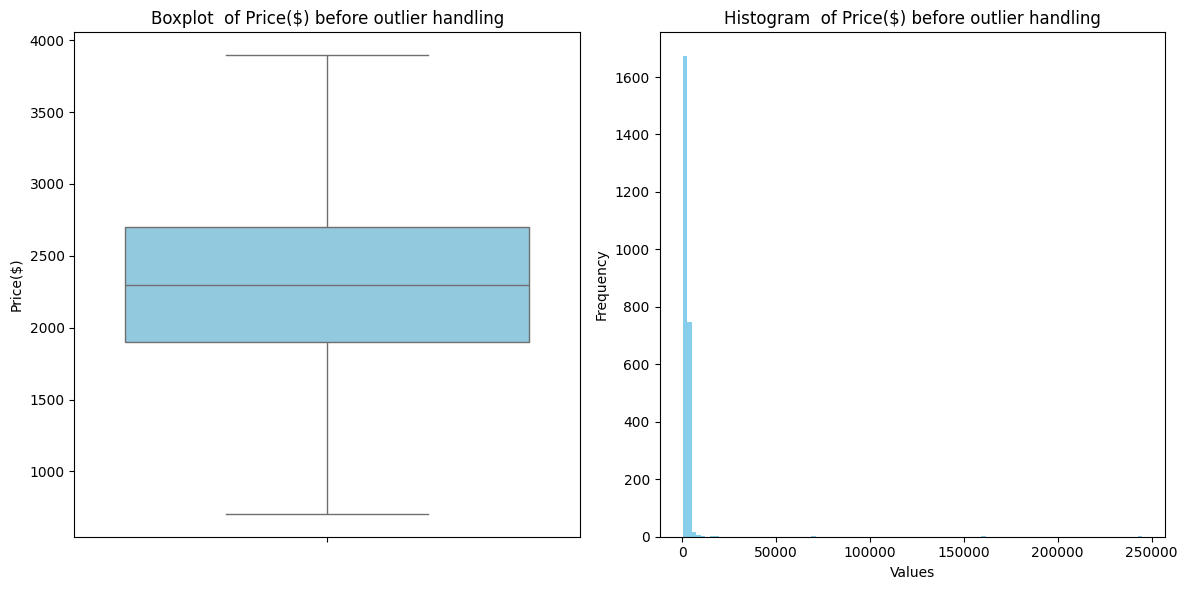

In [88]:
generate_plots(df,'Price($)')

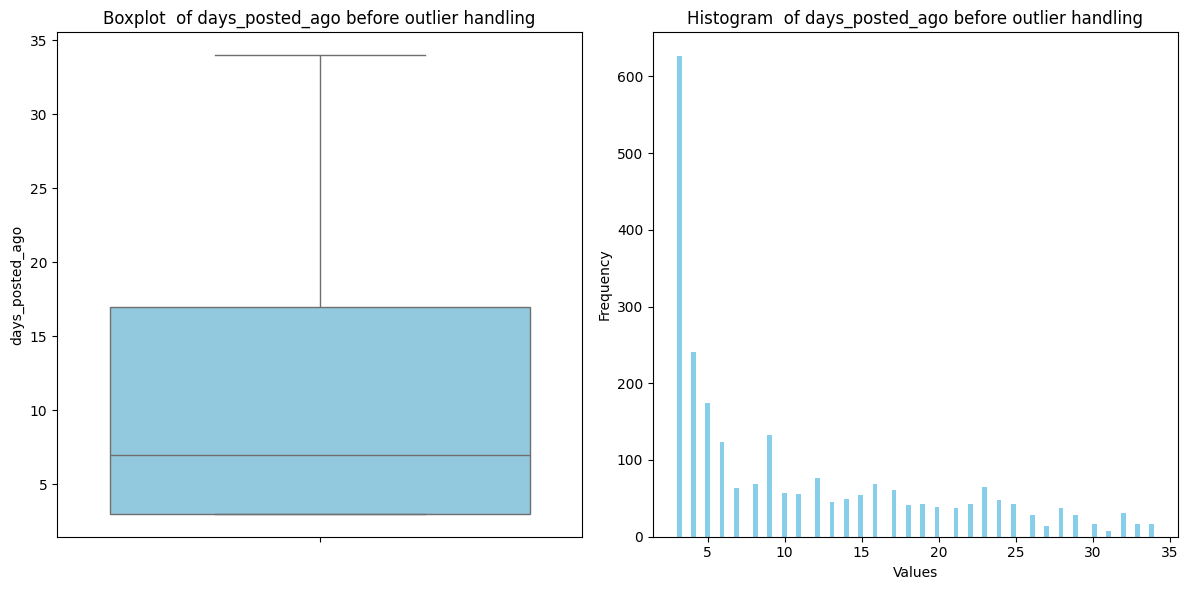

In [89]:
generate_plots(df,'days_posted_ago')

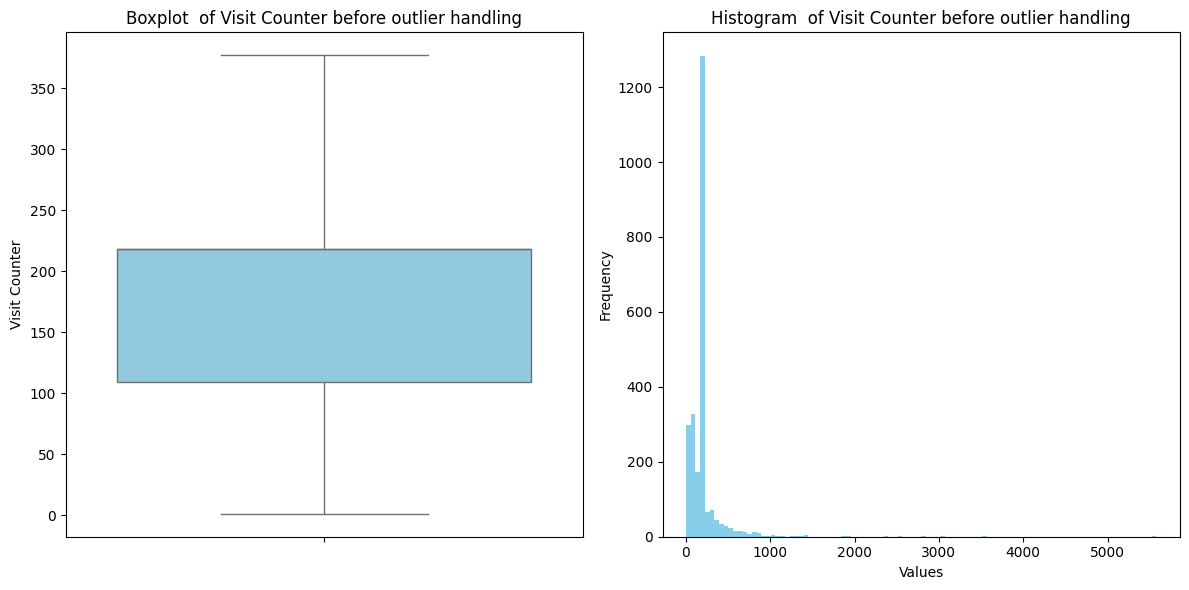

In [90]:
generate_plots(df,'Visit Counter')

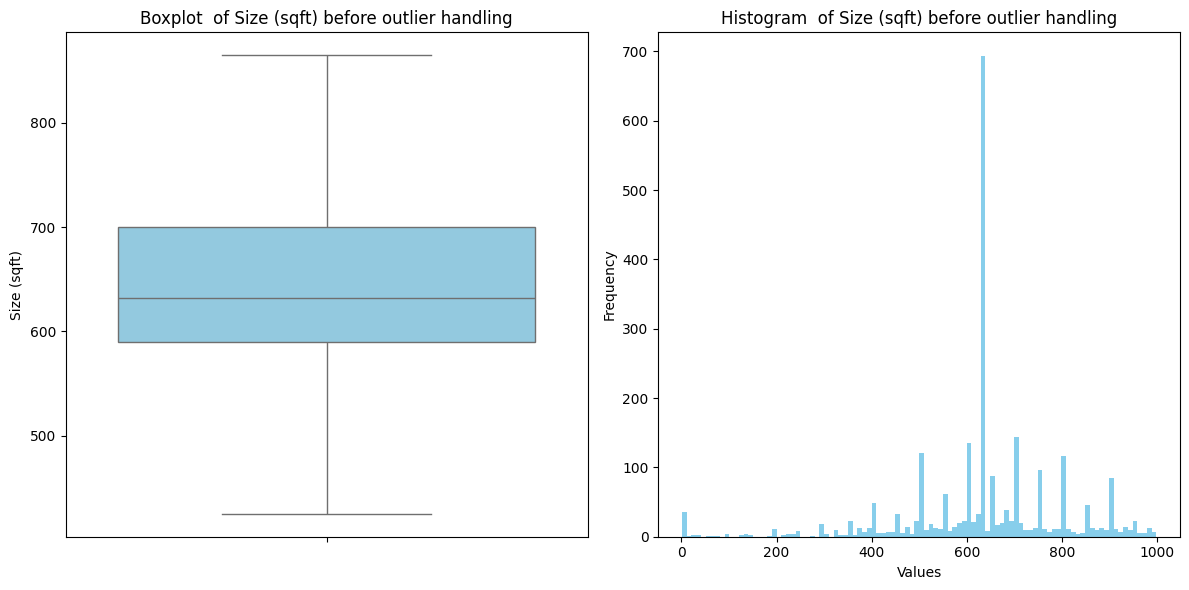

In [91]:
generate_plots(df,'Size (sqft)')

**Observation** <br>
Analyzing the Box plot of 4 numerical columns ,3 of them Price, Visit Counter and days_posted_ago are Right skewed. Only Size (sqft) exhibits normal distribution, suggesting use of Outliers handling on the dataset.

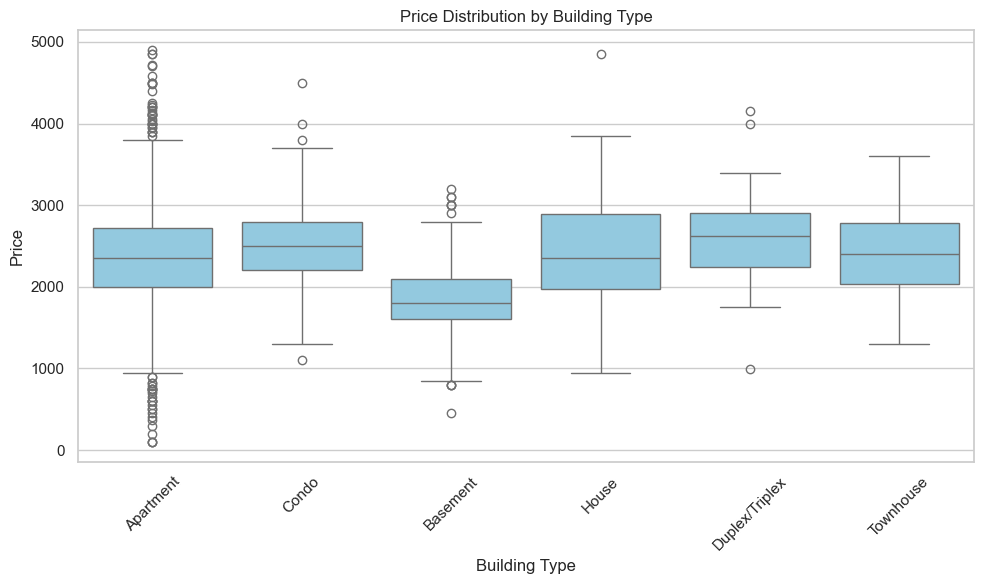

In [92]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Building Type', y='Price($)', data=filtered_df, color='skyblue')

# Add title and labels
plt.title('Price Distribution by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Price')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


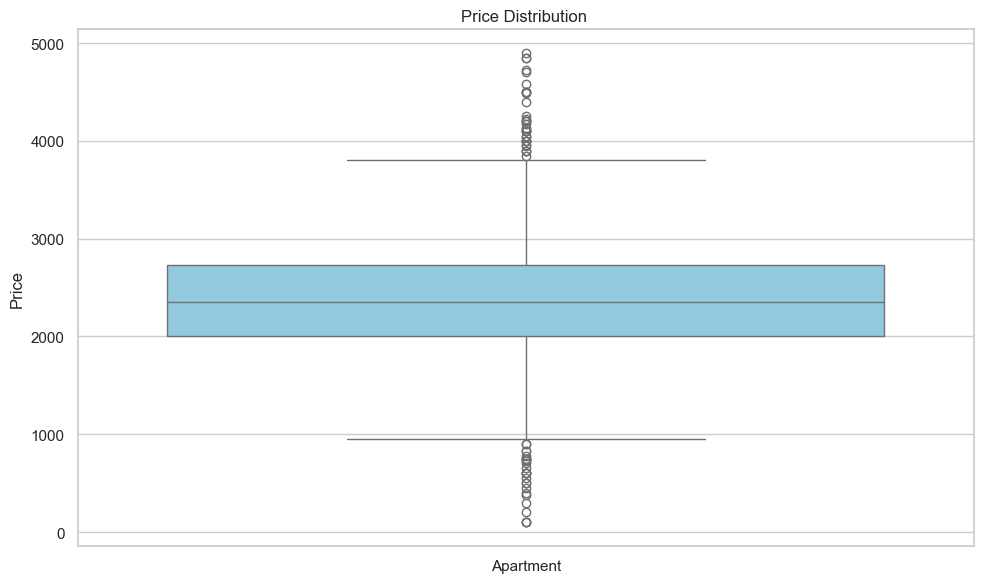

In [93]:
# Filter the DataFrame to include only 'Apartment' building type
apartment_df = filtered_df[filtered_df['Building Type'] == 'Apartment']

# Set the style for seaborn
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Building Type', y='Price($)', data=apartment_df, color='skyblue')

# Add title and labels
plt.title('Price Distribution ')
plt.xlabel('')
plt.ylabel('Price')

# Show the plot
plt.tight_layout()
plt.show()


**Observation** <br>
All Building type has IQR in range of 2000 - 3000 except for Basement which is a bit lower. Building type Apartment has most outliers followed by Basement and Condo while other building type has very small number of outliers

## Step 7: Outlier Treatment

**7.1 Quantile based Flooring and Capping**

In [94]:
def quantile_flooring_and_capping(df, columns_to_process, floor_quantile=0.1, cap_quantile=0.9):
    # copy the dataframe to avoid modifying original
    df_processed = df.copy()

    # Iterate over each column to process
    for column in columns_to_process:
        # Calculate thresholds for flooring and capping
        floor_threshold = df_processed[column].quantile(floor_quantile)
        cap_threshold = df_processed[column].quantile(cap_quantile)

        # Floor values below the floor threshold
        df_processed[column] = df_processed[column].apply(lambda x: floor_threshold if x < floor_threshold else x)

        # Cap values above the cap threshold
        df_processed[column] = df_processed[column].apply(lambda x: cap_threshold if x > cap_threshold else x)

    return df_processed

In [95]:
df_flooring_and_capping = quantile_flooring_and_capping(df, outlier_columns)

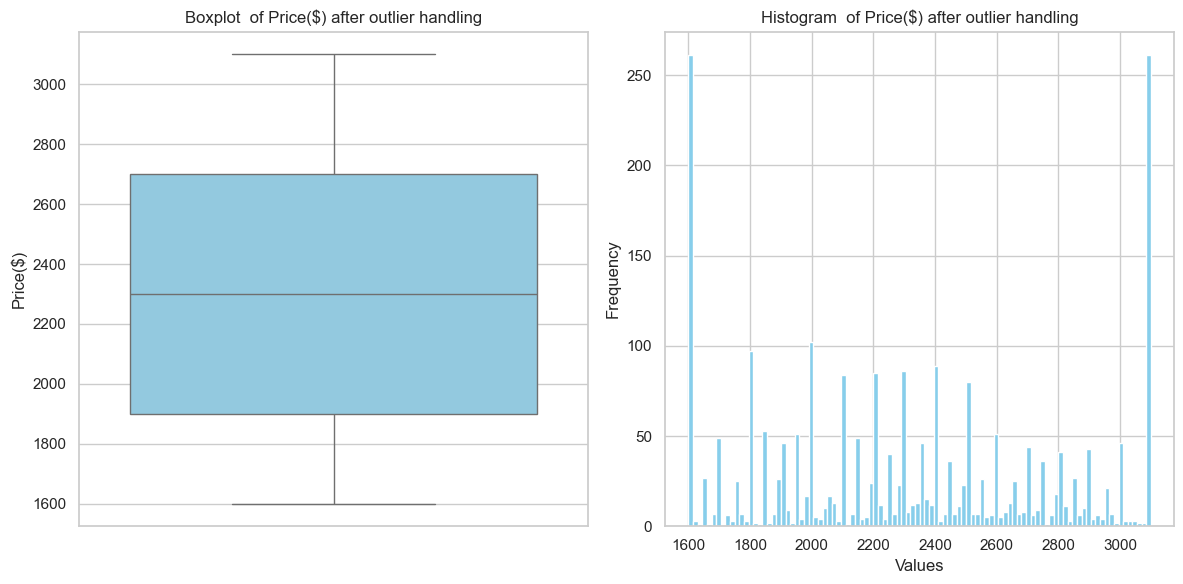

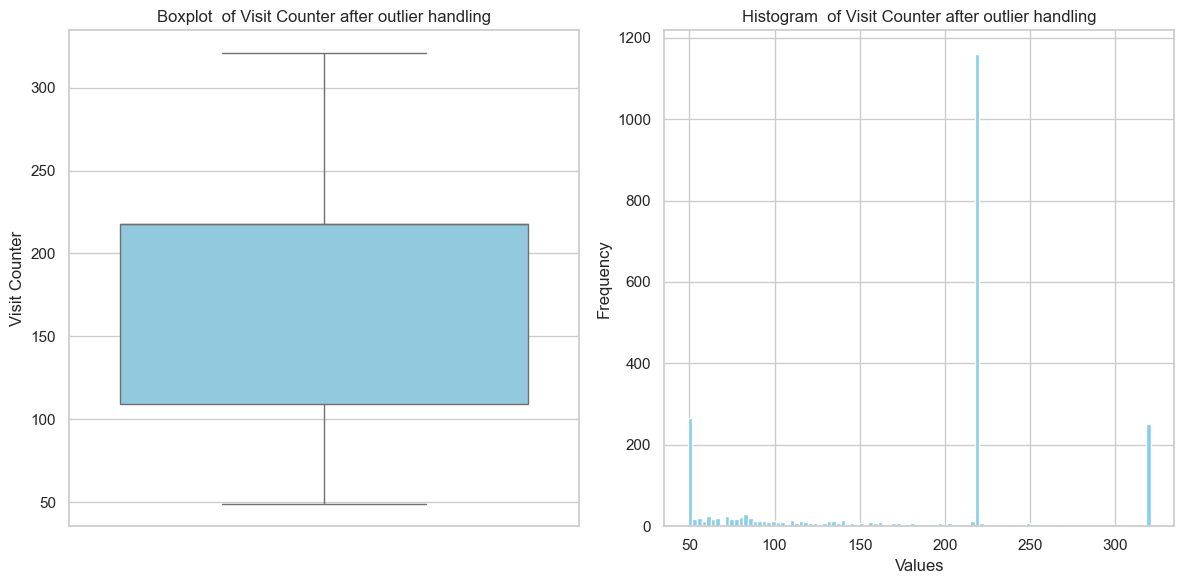

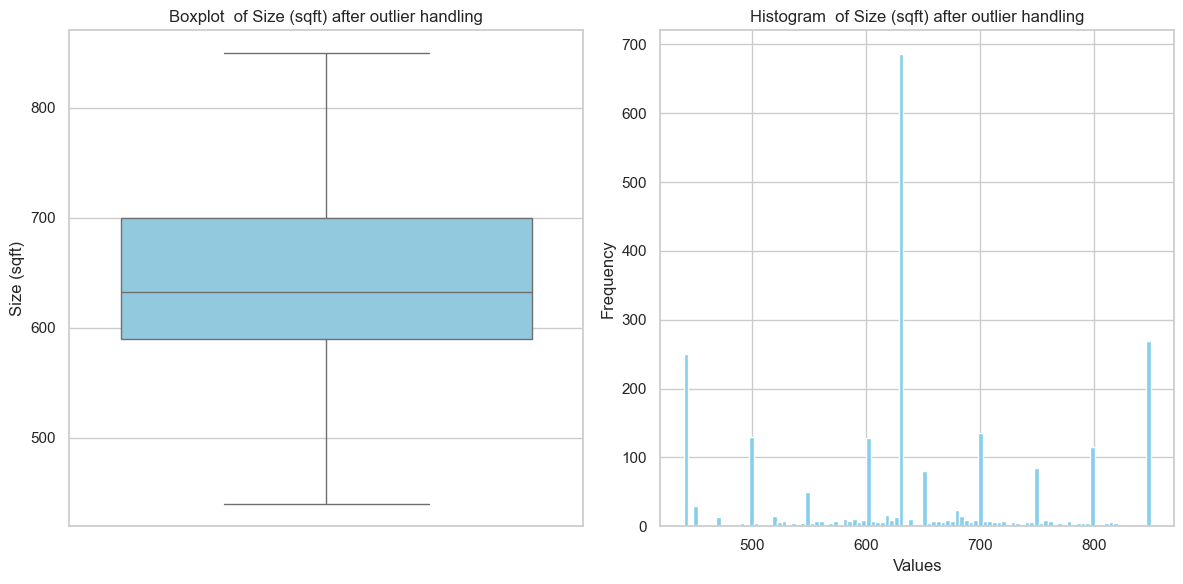

In [96]:
for col in outlier_columns:
  generate_plots(df_flooring_and_capping,col, True)

**Observation**

Flooring and capping has given better result for Price and Visitoe count but for Days count remaining it has shown minor impact only

**7.2 Trimming**

In [97]:
def trimming(df, columns_to_process, trim_lower=0.1, trim_upper=0.9):
    # copy the dataframe to avoid modifying original
    df_trimmed = df.copy()


    # Iterate over each column to process
    for column in columns_to_process:
        # Calculate lower and upper trim thresholds
        lower_threshold = df_trimmed[column].quantile(trim_lower)
        upper_threshold = df_trimmed[column].quantile(trim_upper)

        # Remove outliers by trimming
        df_trimmed = df_trimmed[(df_trimmed[column] >= lower_threshold) & (df_trimmed[column] <= upper_threshold)]

    return df_trimmed

In [98]:
df_trimmed = trimming(df, outlier_columns)

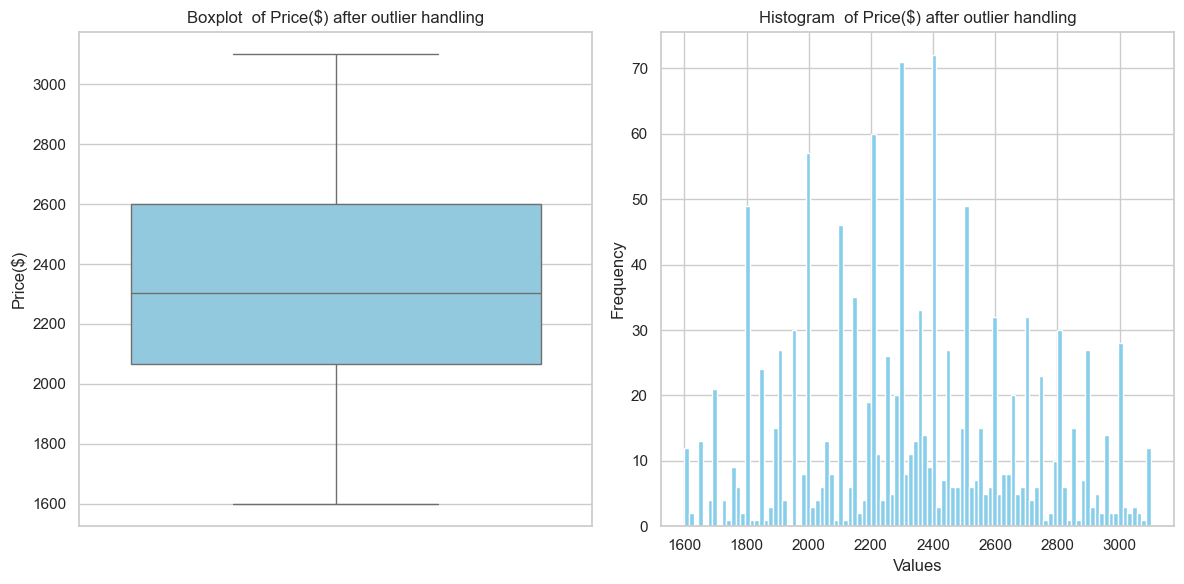

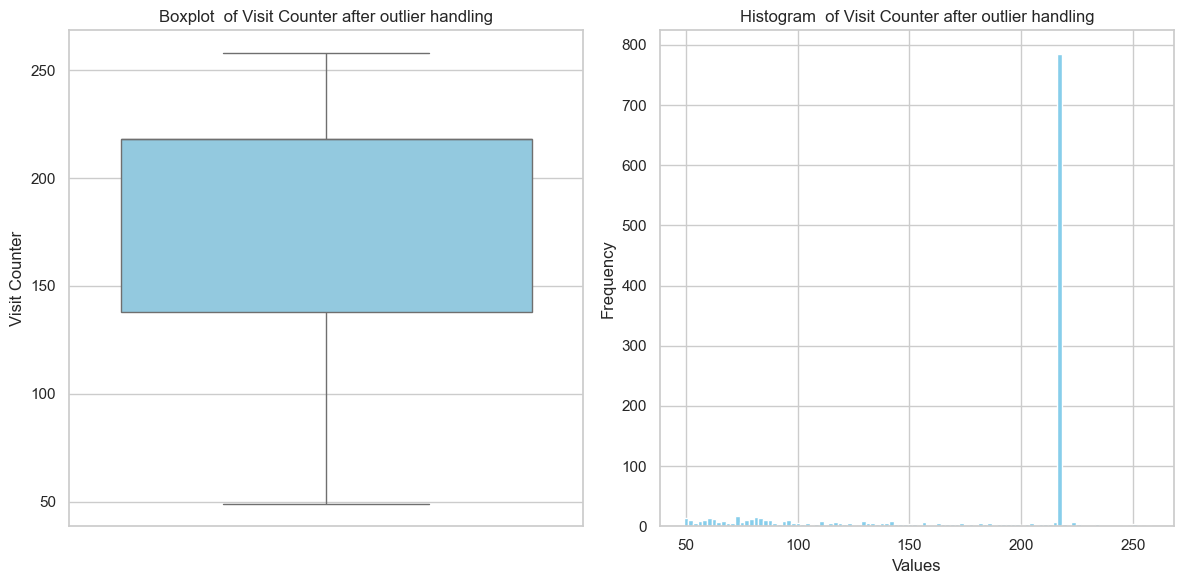

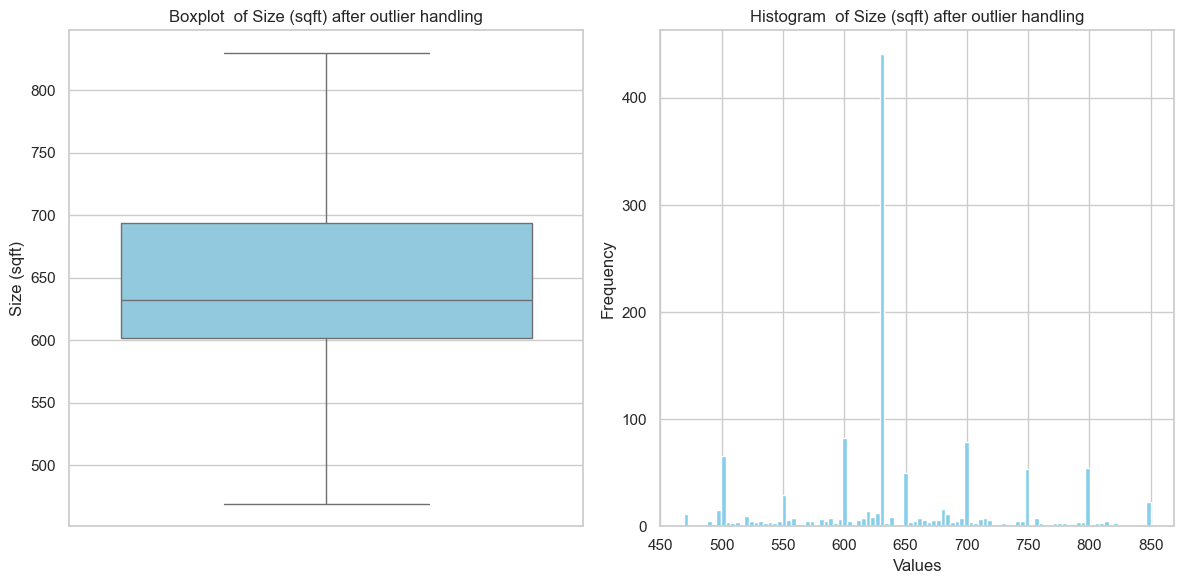

In [99]:
for col in outlier_columns:
  generate_plots(df_trimmed,col, True)

**Observation** <br>
Trimming has better impact on the data towards converging them to normal distribution as compared to Quantile based Flooring and Capping

**7.3 Log Transformation**

In [100]:
import numpy as np

def log_transform(df, column):
    # Make a copy of the DataFrame to avoid modifying the original data
    df_log_transformed = df.copy()

    # Apply log transformation to the specified column
    df_log_transformed[column] = np.log(df_log_transformed[column])

    return df_log_transformed


In [101]:
df_log = log_transform(df, outlier_columns)

In [102]:
for column in outlier_columns:
    # Check for negative or zero values in the columns
    negative_values = (df[column] < 0).sum()
    zero_values = (df[column] == 0).sum()
    print(column)

    # Print the counts
    print(f"Number of negative values: {negative_values}")
    print(f"Number of zero values: {zero_values}")

    # Check if there are any negative or zero values
    if negative_values > 0 or zero_values > 0:
        print("Warning: The column contains negative or zero values. Log transformation may not be appropriate.")
    else:
        print("No negative or zero values found. Log transformation can be applied.")


Price($)
Number of negative values: 0
Number of zero values: 0
No negative or zero values found. Log transformation can be applied.
Visit Counter
Number of negative values: 0
Number of zero values: 0
No negative or zero values found. Log transformation can be applied.
Size (sqft)
Number of negative values: 0
Number of zero values: 0
No negative or zero values found. Log transformation can be applied.


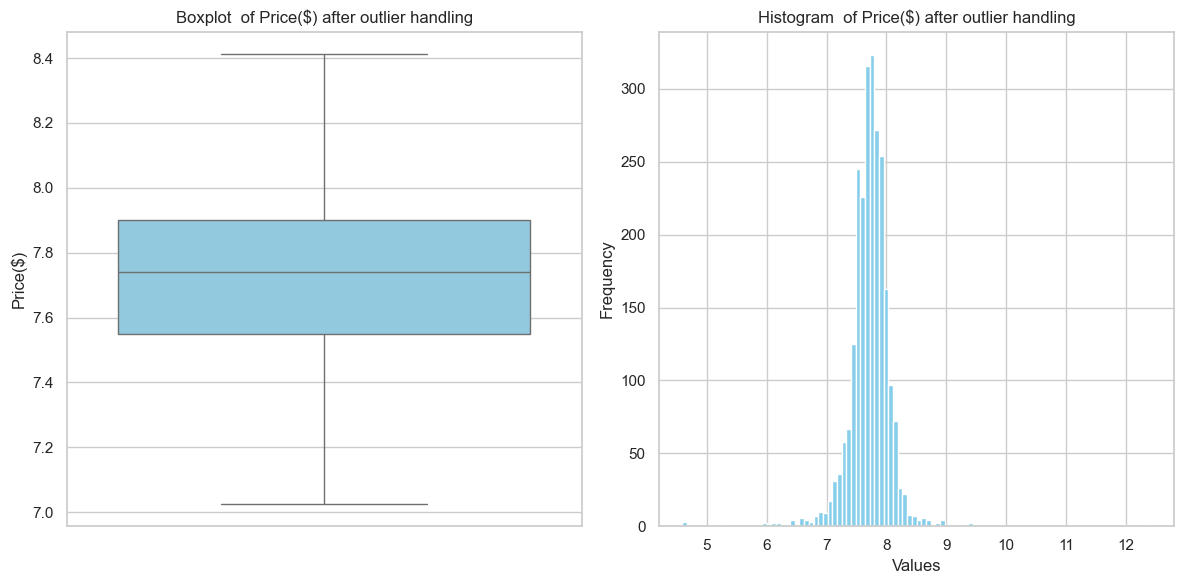

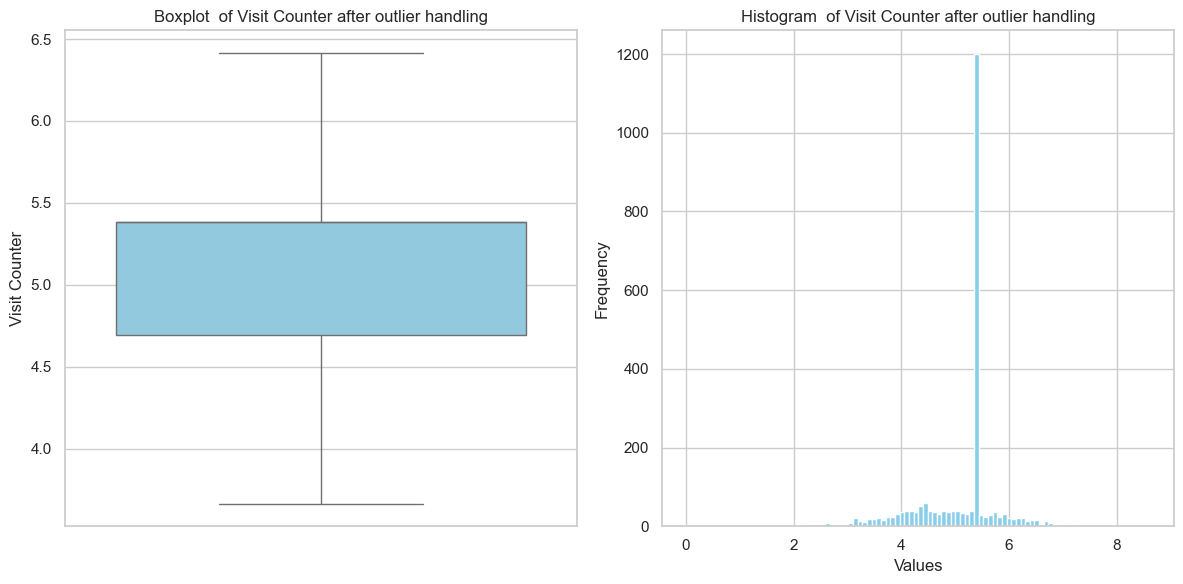

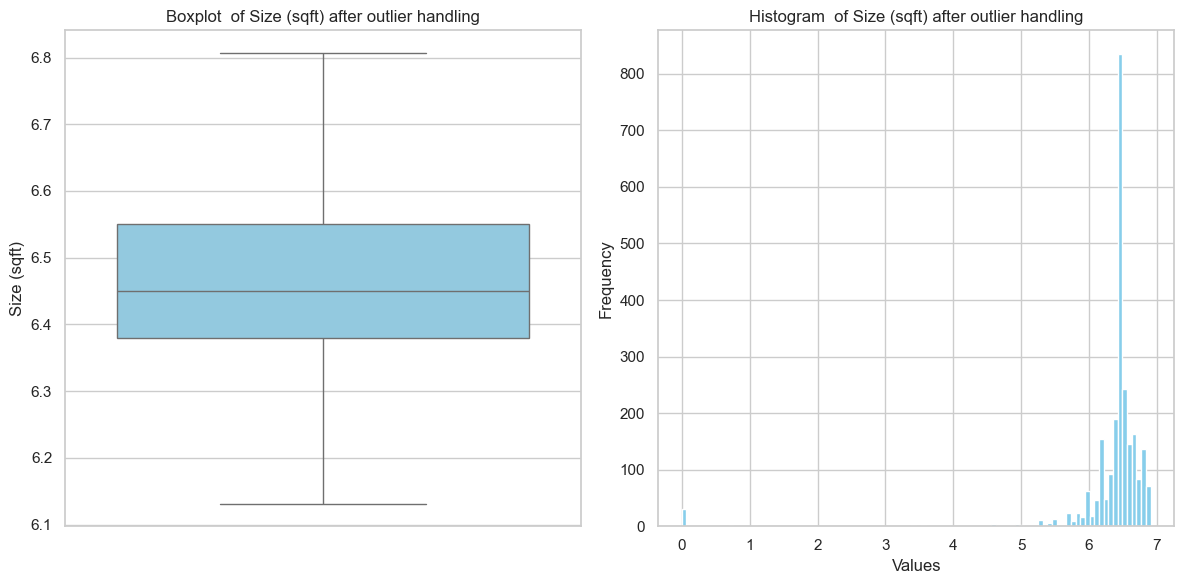

In [103]:
for col in outlier_columns:
  generate_plots(df_log,col, True)

**Observation** <br>
All the data seems to have normal distribution after log transformation. Price plot suggest that data are in almost-perfect normal distribution. Visitor count and Size also exhibits normal distribution with some anomalies.Size seems to be left skewed and Visitor count still has some data exhibiting the character of outliers.

## Step 8: Using Unsupervised Learning method

**8.1 Optimal Cluster number (Elbow Method)**

In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Extract numerical columns from the DataFrame
numerical_columns = ['Size (sqft)', 'Price($)']
numerical_data = df_trimmed[numerical_columns]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical data
scaled_data = scaler.fit_transform(numerical_data)


In [105]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [106]:
kmeans.fit(scaled_data)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [107]:
kmeans.n_iter_

16

In [108]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

In [109]:
X = df_trimmed['Size (sqft)'].values
y = df_trimmed['Price($)'].values

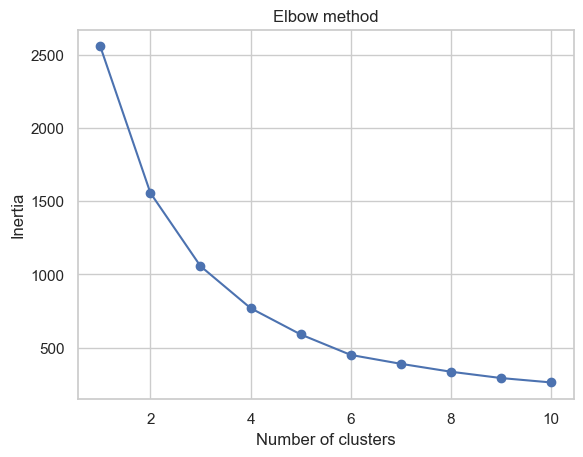

In [110]:
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

**Observation** <br>
Visualizing the Elbow method, we can set k= 5 to 7 so the selected clusters will give the best result in term of simplicity, resource efficincy, avoiding overfitting and interpretability.

**8.2 K-Means Clustering**

In [111]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Choose the number of clusters (k)
k = 5

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

**8.3 Agglomerative Clustering**

In [112]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# Choose the number of clusters (k)
k = 5

# Apply agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=k)
agglo_labels = agglo.fit_predict(scaled_data)

**8.4 Visual Comparision**

**8.4.1 Comparision in 2D plane**

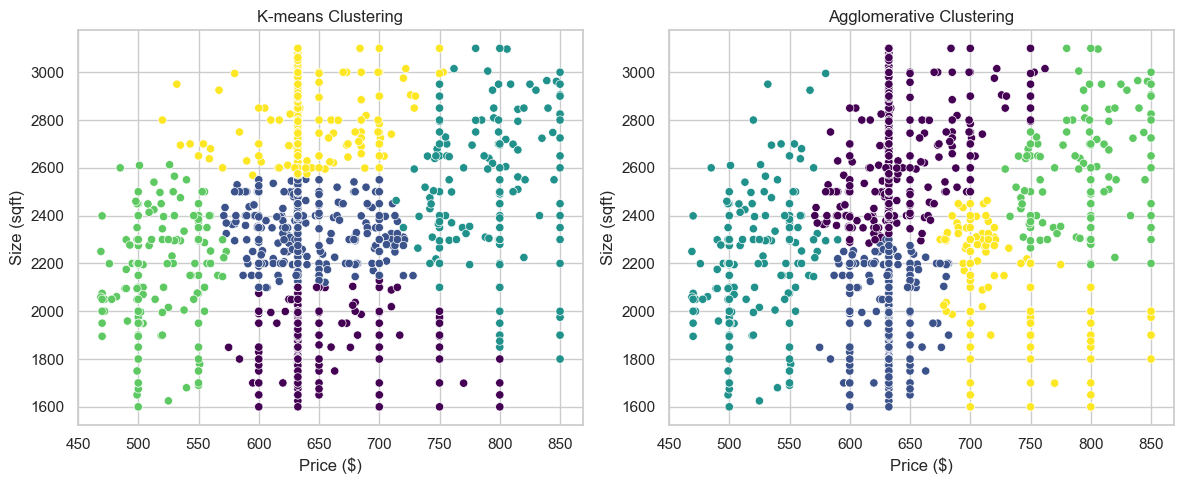

In [113]:
# Visualize the clusters
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X, y=y, hue=kmeans_labels, palette='viridis', legend=False)
plt.title('K-means Clustering')
plt.xlabel('Price ($)')
plt.ylabel('Size (sqft)')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X, y=y, hue=agglo_labels, palette='viridis', legend=False)
plt.title('Agglomerative Clustering')
plt.xlabel('Price ($)')
plt.ylabel('Size (sqft)')

plt.tight_layout()
plt.show()

**8.4.2 Comparision in 3D plane**

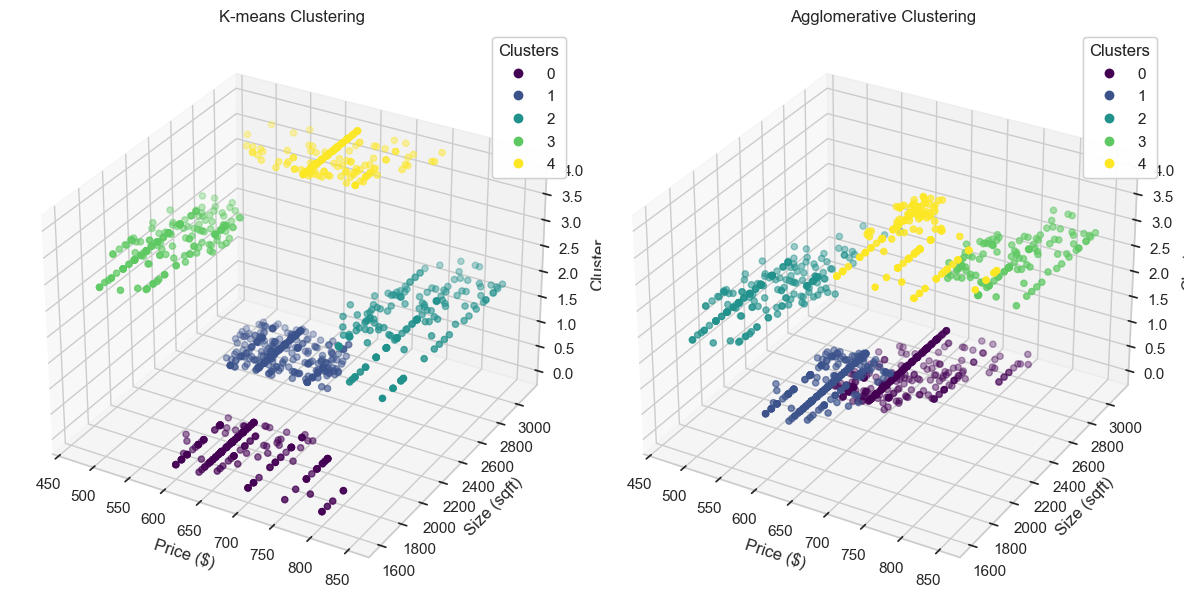

In [114]:
from mpl_toolkits.mplot3d import Axes3D

# Visualize the clusters in 3D
fig = plt.figure(figsize=(12, 6))

# K-means clustering
ax = fig.add_subplot(1, 2, 1, projection='3d')
scatter = ax.scatter(X, y, kmeans_labels, c=kmeans_labels, cmap='viridis')
ax.set_title('K-means Clustering')
ax.set_xlabel('Price ($)')
ax.set_ylabel('Size (sqft)')
ax.set_zlabel('Cluster')
legend1 = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend1)

# Agglomerative clustering
ax = fig.add_subplot(1, 2, 2, projection='3d')
scatter = ax.scatter(X, y, agglo_labels, c=agglo_labels, cmap='viridis')
ax.set_title('Agglomerative Clustering')
ax.set_xlabel('Price ($)')
ax.set_ylabel('Size (sqft)')
ax.set_zlabel('Cluster')
legend2 = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend2)

plt.tight_layout()
plt.show()


**8.5 Result Comparision**

In [115]:
# Evaluate silhouette score and Calinski-Harabasz index for both algorithms
silhouette_kmeans = silhouette_score(scaled_data, kmeans_labels)
silhouette_agg = silhouette_score(scaled_data, agglo_labels)

calinski_kmeans = calinski_harabasz_score(scaled_data, kmeans_labels)
calinski_agg = calinski_harabasz_score(scaled_data, agglo_labels)

bouldin_kmeans = davies_bouldin_score(scaled_data, kmeans_labels)
bouldin_agg = davies_bouldin_score(scaled_data, agglo_labels)


In [116]:
# Create a list of lists containing the data
data = [
    ['K-Means', silhouette_kmeans, calinski_kmeans, bouldin_kmeans],
    ['Agglomerative', silhouette_agg, calinski_agg, bouldin_agg]
]

# Define the column headers
headers = ["Algorithm", "Silhouette Score", "Calinski-Harabasz Score", "Davies-Bouldin Score"]

# Print the table using tabulate
print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

╒═══════════════╤════════════════════╤═══════════════════════════╤════════════════════════╕
│ Algorithm     │   Silhouette Score │   Calinski-Harabasz Score │   Davies-Bouldin Score │
╞═══════════════╪════════════════════╪═══════════════════════════╪════════════════════════╡
│ K-Means       │           0.41157  │                  1062.15  │               0.782769 │
├───────────────┼────────────────────┼───────────────────────────┼────────────────────────┤
│ Agglomerative │           0.397486 │                   896.752 │               0.901663 │
╘═══════════════╧════════════════════╧═══════════════════════════╧════════════════════════╛


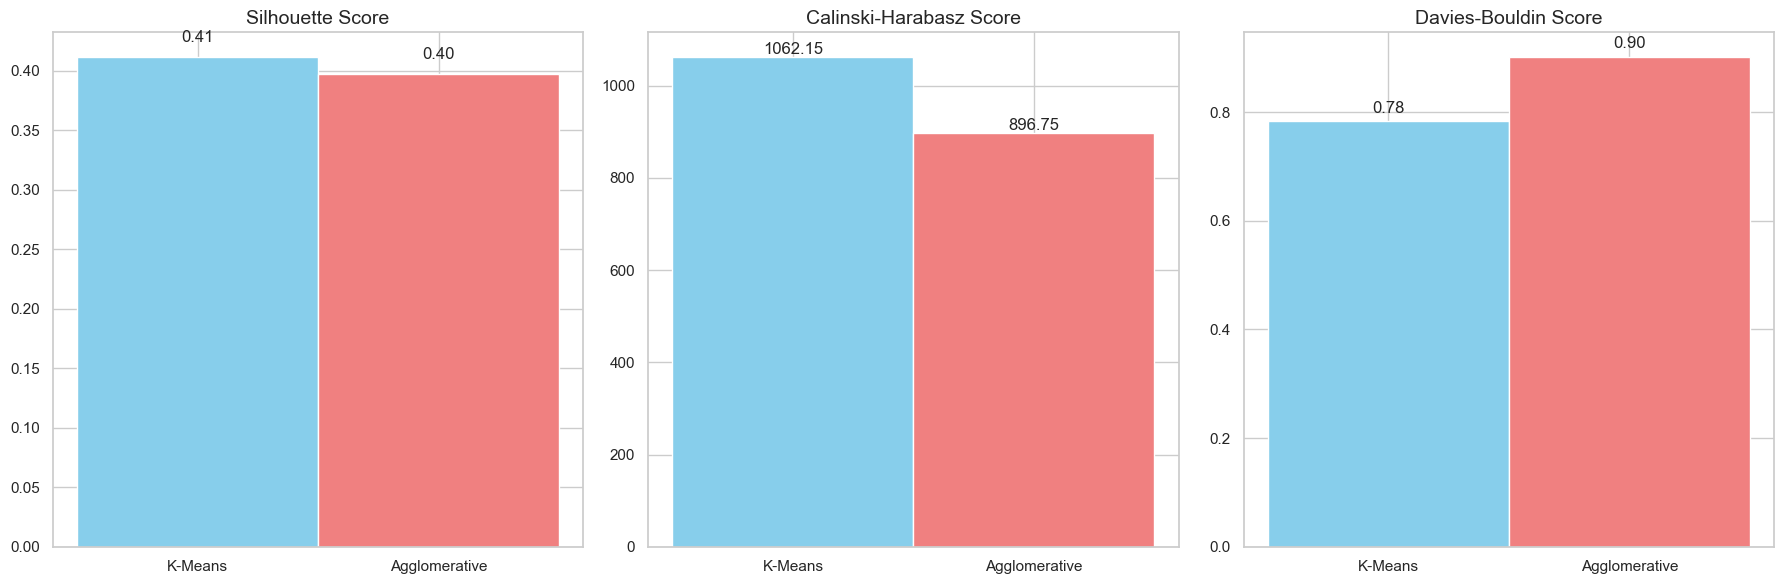

In [117]:
algorithms = ['K-Means', 'Agglomerative']
scores = ['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score']
kmeans_scores = [silhouette_kmeans, calinski_kmeans, bouldin_kmeans]
agglo_scores = [silhouette_agg, calinski_agg, bouldin_agg]

# Set width of bars
bar_width = 0.35
index = np.arange(len(scores))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, score in enumerate(scores):
    # Plotting
    ax = axs[i]
    ax.bar([0], [kmeans_scores[i]], bar_width, label='K-Means', color='skyblue')
    ax.bar([bar_width], [agglo_scores[i]], bar_width, label='Agglomerative', color='lightcoral')

    # Add labels and title
    # ax.set_ylabel('Score', fontsize=12)
    ax.set_title(score, fontsize=14)
    ax.set_xticks([0, bar_width])
    ax.set_xticklabels(['K-Means', 'Agglomerative'])

    # Print value on top of each bar
    for j, v in enumerate([kmeans_scores[i], agglo_scores[i]]):
        ax.text(j * bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()


**Observation**
K-Means outperforms Agglomerative clustering across two metrics:<br>
  Silhouette Score: <br> K-Means achieves a higher score (0.4146) compared to Agglomerative (0.3974), indicating better cluster separation. <br>
  Calinski-Harabasz Score: <br> K-Means has a higher score (1063.01) than Agglomerative ( 896.752), indicating denser, more well-separated clusters. <br>
  Davies-Bouldin Score:  <br>K-Means obtains a lower score (0.901663) compared to Agglomerative (1.94707), suggesting better cluster validity and compactness.

## Step 9: Implementing NLP technique

In [118]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TravelMate\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TravelMate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TravelMate\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**9.1 Text Pre-processing**

In [119]:
def preprocess_text(text):
    text = str(text)
    # convert to lowercase
    text = text.lower()

    text = clean_text(text)

    # Tokenization
    tokens = word_tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]


    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Reconstruct the cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# function to handle text processing and return clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', text)  # Remove emails
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [120]:
# apply preprocessing in data and add it as a new column
df['title_description_text'] = df['Title'] + ' ' + df['Description'] + ' ' + df['Address']

In [121]:
# apply preprocessing in data and add it as a new column
df['title_description_text'] = df['title_description_text'].apply(preprocess_text)

In [122]:
df['title_description_text'].head()

0    bathurst street valencia tower apartment rent ...
1    renovated bachelor suite available lakeview to...
2    driftwood ruby height apartment rent ruby heig...
3    bed apartment rent today limited time receive ...
4    brand new bedroom rental north york york mill ...
Name: title_description_text, dtype: object

In [123]:
def generate_word_cloud(data, title, bg_color):
    if isinstance(data, list):
      data = ' '.join(data)

    wordcloud = WordCloud(width=800, height=400, random_state=42, max_words=100,
                          background_color=bg_color).generate(data)


    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

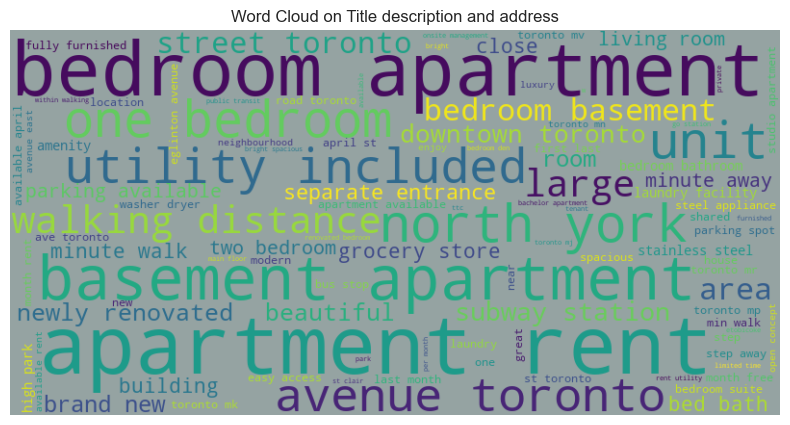

In [124]:
text = " ".join(i for i in df.title_description_text)
wordcloud = WordCloud().generate(text)
generate_word_cloud(text, 'Word Cloud on Title description and address' , '#95A3A2')

In [125]:
# similarity detection in descreption
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['title_description_text'])

# Computing cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


print("Similarity Matrix:")
print(cosine_sim)

Similarity Matrix:
[[1.         0.17207769 0.21859227 ... 0.01514111 0.07124928 0.08491843]
 [0.17207769 1.         0.10762112 ... 0.04191906 0.09804037 0.01903493]
 [0.21859227 0.10762112 1.         ... 0.03785757 0.10845623 0.07604705]
 ...
 [0.01514111 0.04191906 0.03785757 ... 1.         0.         0.05817816]
 [0.07124928 0.09804037 0.10845623 ... 0.         1.         0.04642026]
 [0.08491843 0.01903493 0.07604705 ... 0.05817816 0.04642026 1.        ]]


**9.2 Search Enhancement Using Cosine Similarity**

In [126]:
user_query = "cheaper condo basement downtown"

# Process user query
processed_query = preprocess_text(user_query)

# Vectorize user query
query_vector = tfidf_vectorizer.transform([processed_query])

# Calculate cosine similarity between user query vector and descriptions
similarity_scores = cosine_similarity(query_vector, tfidf_matrix)

# Rank listings based on similarity scores
ranked_indices = similarity_scores.argsort()[0][::-1]  # Sort indices in descending order of similarity scores

# Return top N results to the user
top_n = 5  # Number of results to return
top_listings = df.iloc[ranked_indices[:top_n]]



In [127]:
# Printing  top listings
print("Top Search Results:")
top_listings[['Title', 'Building Type', 'Price($)', 'Address']]


Top Search Results:


,Title,Building Type,Price($),Address
3836,1 bedroom Condo Style Basement Apartment,Basement,1800.0,"York, ON M6E 3N6"
1959,LUXURY 3 BEDROOM CONDO WITH A LAKE VIEW FOR RE...,Condo,3700.0,"York Street, Toronto, ON"
926,2 Bedroom Basement Apartment in Downtown Toronto,Basement,2000.0,"Henry St, Toronto, ON M5T"
3426,1 Bed 1 Bath - Downtown Toronto Condo $2300,Condo,2300.0,"Tecumseth Street, Toronto, ON"
3897,1 Bed 1 Bath - Downtown Toronto Condo $2300,Condo,2300.0,"Tecumseth Street, Toronto, ON"


# 10. Conclusion

To sum up, the process started with Toronto's Kijiji rental data being scraped. After then, methods for data cleaning and visualization were used to guarantee data quality and obtain insights. Categorical variables were prepared for analysis using label encoding and custom encoding. Following the completion of outlier detection, flooring, capping, log transformation, and dropping procedures were applied to the outliers as needed. The ideal number of clusters for k-means and agglomerative clustering was found using the elbow approach. The combination of the address, description, and title fields was further analyzed using NLP techniques, producing word clouds and improved search functionality through the use of cosine similarity. These actions enabled the creation of insightful information for decision-making processes and helped to conduct a thorough examination of the rental data overall.

# 11. Future Improvements
While the evaluated models provide valuable insights into Rental trend analysis, there are several areas that offer potential for future improvement and refinement. These areas are crucial to enhance the accuracy and effectiveness of the models in real-world scenarios:

*  **Feature Engineering:** Exploring more advanced feature engineering techniques could lead to the identification of new relevant features that contribute to better predictive performance. By extracting more informative features from the dataset, the models could capture underlying patterns more effectively.
*   **Use of Larger Dataset:** Current dataset consist of small timeframe and limited number of data which gives unexpected observation in EDA such as Price of 2 Bedrooms is greater than 4 Bedrooms, which might be due to misrepresentation of certain category of data.Using Larger dataset can help with the issue of misrepresentation
* **Using Supervised ML algorithms:** Exploring supervised machine learning techniques, could uncover patterns in the data that might have been overlooked by unsupervised model.

Incorporating these suggestions into the development and refinement of the predictive models will pave the way for more accurate and reliable stroke outcome predictions, ultimately benefiting patients and healthcare practitioners in making informed decisions.

***********The End******************